# Project 2 – Integer Programming

<span style="font-size:20px">**Problem Overview**</span>

Companies invest millions of dollars into marketing every year, yet budget allocation decisions are often based on intuition rather than data. This project aims to replace guesswork with mathematical optimization.

Given a fixed $10 million marketing budget, the goal is to determine how much money should be allocated to different advertising platforms (e.g., TV, Print, Facebook, SEO, etc.) in order to maximize total return on investment (ROI). Each platform has multiple spending tiers, and each tier yields a different ROI based on diminishing returns.

Using the ROI data provided (in CSV files), we build optimization models that decide:

* How much to invest in each platform

* Which spending tiers to use

* How to satisfy business constraints on spending between mediums

When ROIs decrease consistently, the problem is formulated as a linear program. When they do not, we convert it into a mixed integer program to ensure valid tier selection. The models are solved using Gurobi to compute the most profitable allocation of the marketing budget.

The purpose of this project is to demonstrate how integer programming can guide fact-based marketing decisions, ensuring that the budget allocation produces the highest possible return under real-world constraints.

# Data Preparation and Model Setup

We begin the project by loading the marketing ROI datasets that will drive our optimization model. These files contain the estimated return on investment for each advertising platform at different spending tiers. The optimization model reads these values directly to determine how to allocate the $10M marketing budget.

The primary dataset, ***roi_company1.csv***, provides ROI percentages for each platform and spending tier and is used to build our initial allocation model. A second dataset, ***roi_company2.csv***, offers an alternative set of ROI estimates from a different consulting firm, allowing us to compare allocations under different assumptions. Additional supporting files include ***min_amount.csv***, which specifies the minimum spend required for a platform to have any impact, and ***roi_monthly.csv***, which contains month-by-month ROI values for modeling dynamic budgeting across multiple months.

All datasets are loaded into the Python model and serve as the input for constructing the linear programming and mixed-integer programming formulations.

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

## Data Loading

In [2]:
# ========================= IMPORTANT =========================
# All analysis below derives from these data sources:
#   - roi_company1_path : static concave ROI tiers
#   - roi_company2_path : non-concave ROI tiers
#   - min_amount_path   : platform-wise minimum spend
#   - roi_monthly_path  : monthly ROI with reinvestment
# =============================================================

roi_company1_path = "roi_company1.csv"
roi_company2_path = "roi_company2.csv"
min_amount_path   = "min_amount.csv"
roi_monthly_path  = "roi_monthly.csv"

roi_company1 = pd.read_csv(roi_company1_path)
roi_company2 = pd.read_csv(roi_company2_path)
min_amount   = pd.read_csv(min_amount_path)
roi_monthly  = pd.read_csv(roi_monthly_path)

# Standardize infinities where present
for df in (roi_company1, roi_company2):
    df["UpperBound"] = df["UpperBound"].astype(str).replace("inf", str(np.inf)).astype(float)

In [3]:
print("Company 1 ROI data:")
display(roi_company1.head())

print("\nCompany 2 ROI data:")
display(roi_company2.head())

print("\nMinimum Investment Amounts:")
display(min_amount.head())

print("\nMonthly ROI data:")
display(roi_monthly.head())

Company 1 ROI data:


,Platform,Tier,LowerBound,UpperBound,ROI
0,Print,1,0.00,0.70,0.03
1,Print,2,0.70,2.70,0.03
2,Print,3,2.70,4.70,0.03
3,Print,4,4.70,inf,0.02
4,TV,1,0.00,4.30,0.06



Company 2 ROI data:


,Platform,Tier,LowerBound,UpperBound,ROI
0,Print,1,0.00,2.60,0.05
1,Print,2,2.60,inf,0.05
2,TV,1,0.00,1.80,0.02
3,TV,2,1.80,3.80,0.03
4,TV,3,3.80,inf,0.02



Minimum Investment Amounts:


,Platform,MinInvestment
0,Print,0.30
1,TV,0.30
2,SEO,0.60
3,AdWords,0.80
4,Facebook,0.40



Monthly ROI data:


,Month,Platform,Tier,LowerBoundM,UpperBoundM,ROI
0,Jan,Print,1,0.00,6.00,0.06
1,Jan,Print,2,6.00,inf,0.06
2,Jan,TV,1,0.00,2.20,0.02
3,Jan,TV,2,2.20,inf,0.02
4,Jan,SEO,1,0.00,0.40,0.02


# Linear Program Model for Company 1 ROI — Optimal Marketing Budget Allocation

For the given ROI data, the ROI is non-increasing with respect to the invested amount, so the total return is a concave function of the invested amount. To determine the optimal amount invested in different mediums, this marketing budget allocation problem can be formulated as a linear program when the return is concave with respect to ROI. You can let the amounts invested in each tier for each medium be continuous decision variables and then the total invested amount is the sum of them. The concavity of the return function guarantees that the invested amount in a tier is positive only when the invested amounts in previous tiers equal their upper bounds. Use gurobi to find the optimal budget allocation after formulating it as a linear program.

(Using ROI from `roi_company1.csv`)

## Number of Decision Variables

Each decision variable corresponds to a platform–tier pair with positive tier capacity (TierUB_{p,t} > 0).

Let:
- $P$ = set of platforms
- $T_p$ = set of tiers for platform $p$

Define the subset of usable tiers:

$$
T_p^{+} = \{\, t \in T_p \mid TierUB_{p,t} > 0 \,\}
$$

Total number of decision variables:

$$
\#\text{vars} \;=\; \sum_{p \in P} \left| T_p^{+} \right|
$$

## Objective: 

Formulate a linear program to determine how to allocate a fixed **$10M marketing budget** across multiple advertising platforms (Print, TV, Facebook, SEO, etc.) to **maximize total return on investment (ROI)**.

Each platform’s ROI is given in spending tiers. ROI within a tier is constant, but decreases as spending increases to the next tier, making the total return **piecewise linear and concave**.

Mathematical objective:

$$
\text{Maximize } Z = \sum_{p,t} ROI_{p,t} \cdot x_{p,t}
$$


Where:

* x_{p,t} = dollars (in millions) invested in platform p, tier t

* ROI_{p,t} = return percentage for that tier

## Constraints:

The model is subject to four business rules provided by the Chief Marketing Officer.

1. **Total budget cannot exceed $10M**

$$
\sum_{p,t} x_{p,t} \le 10
$$


2. **No platform receives more than $3M**

$$
\sum_{t} x_{p,t} \le 3 \quad \forall p
$$


3. **Piecewise tier widths (capacity of each tier)**
   Each tier allows only a limited amount of investment (TierUB from the CSV):

$$
0 \le x_{p,t} \le TierUB_{p,t} \quad \forall p,t
$$


4. **Print + TV ≤ Facebook + Email**

$$
\sum_{t} x_{\text{Print},t} + \sum_{t} x_{\text{TV},t}
\;\le\;
\sum_{t} x_{\text{Facebook},t} + \sum_{t} x_{\text{Email},t}
$$


5. **Social media ≥ 2 × (SEO + AdWords)**

$$
\sum_{p \in Social} \sum_{t} x_{p,t}
\;\ge\;
2 \cdot \left(
\sum_{t} x_{\text{SEO},t} + \sum_{t} x_{\text{AdWords},t}
\right)
$$

These constraints enforce investment priorities based on business strategy—specifically pushing toward digital/social channels and avoiding overspending on Print and TV.

## Implementation:

* The ROI tier data is loaded from **`roi_company1.csv`**.
* Each tier becomes a decision variable (x_{p,t}) in Gurobi.
* Because ROI decreases by tier (concavity), the model remains a **linear program (LP)** — no binary variables are required.
* Gurobi finds the set of (x_{p,t}) values that produce the **maximum return** while satisfying the budget and strategic constraints.

In [4]:
# PREPROCESSING AND PROBLEM SETUP

df = pd.read_csv(roi_company1_path)

# Convert "inf" in CSV to actual numeric infinity
df["UpperBound"] = df["UpperBound"].astype(str).replace("inf", str(np.inf)).astype(float)

# Model parameters
B   = 10.0   # total budget across all platforms (million dollars)
CAP = 3.0    # max spend allowed on any one platform

# Categories used in business rules
SOCIAL = {"Facebook", "LinkedIn", "Instagram", "Snapchat", "Twitter"}
SEOSEM = {"SEO", "AdWords"}
LHS    = {"Print", "TV"}          # left side of Print + TV ≤ Facebook + Email
RHS    = {"Facebook", "Email"}    # right side

# Compute usable spend range on each tier, respecting platform max
df["TierUB"] = (np.minimum(df["UpperBound"], CAP) - df["LowerBound"]).clip(lower=0)

# Remove tiers where no valid spending is possible
df = df[df["TierUB"] > 0].copy()

print("Number of decision variables:", len(df))


# MODEL AND DECISION VARIABLES

lp_model = gp.Model()
lp_model.Params.OutputFlag = 0   # keep solver silent

# Decision variable:
# lp_x[(platform, tier)] = how much to spend in that tier (continuous variable)
lp_x = lp_model.addVars(
    [(r.Platform, int(r.Tier)) for r in df.itertuples()],
    lb=0.0
)

# Each variable must stay within the valid tier width range
for r in df.itertuples():
    lp_x[(r.Platform, int(r.Tier))].UB = float(r.TierUB)


# CONSTRAINTS

# Total budget cannot exceed $10M
lp_model.addConstr(gp.quicksum(lp_x.values()) <= B)

# Each platform cannot exceed its $3M allowance
for platform_name, group in df.groupby("Platform"):
    lp_model.addConstr(
        gp.quicksum(lp_x[(platform_name, int(t))] for t in group["Tier"]) <= CAP
    )

# Traditional (Print + TV) cannot exceed (Facebook + Email)
lp_model.addConstr(
    gp.quicksum(lp_x[(r.Platform, int(r.Tier))] for r in df.itertuples() if r.Platform in LHS)
    <=
    gp.quicksum(lp_x[(r.Platform, int(r.Tier))] for r in df.itertuples() if r.Platform in RHS)
)

# Social must have at least 2x investment relative to Search (SEO + AdWords)
lp_model.addConstr(
    gp.quicksum(lp_x[(r.Platform, int(r.Tier))] for r in df.itertuples() if r.Platform in SOCIAL)
    >=
    2.0 * gp.quicksum(lp_x[(r.Platform, int(r.Tier))] for r in df.itertuples() if r.Platform in SEOSEM)
)


# OBJECTIVE

# Maximize total expected return = sum(ROI * spend for every tier)
lp_model.setObjective(
    gp.quicksum(r.ROI * lp_x[(r.Platform, int(r.Tier))] for r in df.itertuples()),
    GRB.MAXIMIZE
)

lp_model.optimize()


# REPORTING 

def fmt_money(millions):
    return f"${int(round(millions * 1_000_000)):,}"

if lp_model.status == GRB.OPTIMAL:
    lp_plat_spend = {}
    lp_plat_return = {}
    for r in df.itertuples():
        key = (r.Platform, int(r.Tier))
        val = lp_x[key].X
        if val > 1e-9:
            lp_plat_spend[r.Platform]  = lp_plat_spend.get(r.Platform, 0.0) + val
            lp_plat_return[r.Platform] = lp_plat_return.get(r.Platform, 0.0) + val * r.ROI

    lp_total_spend  = sum(lp_plat_spend.values())
    lp_total_return = sum(lp_plat_return.values())

    print("\n=== Optimal Budget Allocation (LP Solution, Company 1) ===\n")
    print("Total Spend :", fmt_money(lp_total_spend), f"(Budget {fmt_money(B)})")
    print("Total Return:", fmt_money(lp_total_return))
    print("Overall ROI :", f"{100*lp_total_return/lp_total_spend:.2f}%\n")

    print("Platform  | Spend($)     | Return($)    | ROI%")
    print("-" * 52)
    lp_plat_rows = []
    for p in lp_plat_spend:
        s = lp_plat_spend[p]
        r = lp_plat_return[p]
        lp_roi_pc = 100.0 * r / max(s, 1e-12)
        lp_plat_rows.append((p, s, r, lp_roi_pc))
    lp_plat_rows.sort(key=lambda t: -t[3])
    for p, s, r, lp_roi_pc in lp_plat_rows:
        print(f"{p:<9} | {fmt_money(s):>12} | {fmt_money(r):>12} | {lp_roi_pc:>6.2f}")

    lp_allocs = [
        (r.Platform, int(r.Tier), r.ROI, lp_x[(r.Platform, int(r.Tier))].X)
        for r in df.itertuples()
        if lp_x[(r.Platform, int(r.Tier))].X > 1e-9
    ]
    lp_allocs.sort(key=lambda t: (-t[2], t[0], t[1]))

    if lp_allocs:
        print("\nPlatform  | Tier | Spend($)     | Return($)    | ROI%")
        print("-" * 60)
        for p, t, roi, spend in lp_allocs:
            ret = spend * roi
            print(f"{p:<9} | {t:>4} | {fmt_money(spend):>12} | {fmt_money(ret):>12} | {100*roi:>6.2f}")

    lp_spend_print_tv = sum(lp_plat_spend.get(p, 0.0) for p in LHS)
    lp_spend_fb_email = sum(lp_plat_spend.get(p, 0.0) for p in RHS)
    lp_spend_social   = sum(lp_plat_spend.get(p, 0.0) for p in SOCIAL)
    lp_spend_search   = sum(lp_plat_spend.get(p, 0.0) for p in SEOSEM)

    print("\nConstraint checks:")
    print(f"  Budget used ≤ {fmt_money(B)}:         {fmt_money(lp_total_spend)} ≤ {fmt_money(B)}")
    print(f"  Print+TV ≤ Facebook+Email:    {fmt_money(lp_spend_print_tv)} ≤ {fmt_money(lp_spend_fb_email)}")
    print(f"  Social ≥ 2 × Search:          {fmt_money(lp_spend_social)} ≥ {fmt_money(2*lp_spend_search)}")

Number of decision variables: 22
Set parameter Username
Set parameter LicenseID to value 2699630
Academic license - for non-commercial use only - expires 2026-08-25

=== Optimal Budget Allocation (LP Solution, Company 1) ===

Total Spend : $10,000,000 (Budget $10,000,000)
Total Return: $543,640
Overall ROI : 5.44%

Platform  | Spend($)     | Return($)    | ROI%
----------------------------------------------------
TV        |   $3,000,000 |     $182,400 |   6.08
Instagram |   $3,000,000 |     $171,440 |   5.71
Email     |   $3,000,000 |     $147,900 |   4.93
AdWords   |   $1,000,000 |      $41,900 |   4.19

Platform  | Tier | Spend($)     | Return($)    | ROI%
------------------------------------------------------------
TV        |    1 |   $3,000,000 |     $182,400 |   6.08
Instagram |    1 |   $2,900,000 |     $166,460 |   5.74
Instagram |    2 |     $100,000 |       $4,980 |   4.98
Email     |    1 |   $3,000,000 |     $147,900 |   4.93
AdWords   |    1 |   $1,000,000 |      $41,900 

## Analysis: Linear Program (Company 1 ROI)

The linear optimization model allocated the full **$10M marketing budget** across the available platforms and tiers based on the highest ROI available under the business constraints. The model used 22 decision variables (one for each platform–tier spending segment with positive tier capacity).

### Allocation Summary

| Platform   | Spend (\$M) | Return (\$M)  | ROI %                 |
|------------|-------------|---------------|---------------------  |
| TV         | 3.000       | 0.182         | 6.08%                 |
| Instagram  | 3.000       | 0.171         | 5.71%                 |
| Email      | 3.000       | 0.148         | 4.93%                 |
| AdWords    | 1.000       | 0.042         | 4.19%                 |
| **Total**  | **10.000**  | **0.544**     | **5.44% overall ROI** |



The tier-level solution shows that the LP behaves as expected with concave ROI. For each platform, the model fully utilizes the highest ROI tier before assigning any spend to the next tier. For example, Instagram receives 2.9M in Tier 1 and only 0.1M in Tier 2, confirming the concavity assumption and validating the structure of the LP.

### Interpretation

* **TV and Instagram absorb the majority of the budget first**, because their Tier 1 ROI levels are the highest among all platforms.
* **Email is heavily funded** (third-largest allocation) because it satisfies the business rule requiring Print + TV ≤ Facebook + Email while still yielding a positive return.
* **AdWords receives only $1M**, which corresponds exactly to its highest ROI tier. Spending more would push the investment into a lower-ROI tier and decrease marginal return.
* No money flows to Print, Facebook, or SEO in this solution, meaning their top-tier ROI values were not competitive relative to the funded platforms.

The overall marketing ROI achieved from the optimal allocation is **5.44%**, generating a projected return of **$0.544M**.

## Recommendation

Based on the linear optimization using Company 1’s concave ROI estimates:

**Allocate the full $10M to TV, Instagram, Email, and AdWords, in that order of priority.**

This portfolio maximizes return while respecting all business rules and spending caps. Based on Consulting Firm 1’s ROI assumptions, this is the profit-maximizing and constraint-feasible allocation.


# Mixed Integer Program for Company 2 ROI — Non-Concave ROI Budget Allocation

While the allocation from the first model is optimal under **Consulting Firm 1’s ROI assumptions**, the CMO expressed concern about relying on a single consulting firm. To validate the robustness of our strategy, the team obtained a second ROI dataset (`roi_company2.csv`).

After analyzing the second dataset, we observed that **the ROI values are not non-increasing across tiers.**

This means that a **higher spending tier may offer a higher ROI** than a previous tier. As a result:

* The total return is **not concave**, and
* A linear program may produce invalid behavior (e.g., skipping a lower tier and investing directly in a higher tier).

Because concavity no longer holds, we must reformulate the problem as a **Mixed Integer Program (MIP)**.

To correctly model the tier selection:

* A **binary variable** (z_{p,t}) is introduced to indicate whether a platform (p) uses tier (t).
* A **continuous variable** (s_{p,t}) determines how much of that selected tier is used through convex interpolation.

The CMO’s business constraints (budget limit, per-platform cap, Print+TV ≤ Facebook+Email, and Social ≥ 2 × SEO+AdWords) remain enforced in the MIP formulation.

## Number of Decision Variables

* Continuous spend per platform: $x_p \in [0,3]$ for each $p \in P$ → **$|P|$** variables
* Binary tier selectors: $z_{p,t} \in \{0,1\}$ for each $t \in T_p$ and $p \in P$ → **$\sum_{p\in P} |T_p|$** variables
* Continuous interpolation within the chosen tier: $s_{p,t} \in [0,1]$ for each $t \in T_p$, $p \in P$ → **$\sum_{p\in P} |T_p|$** variables

Total:

$$
\#\text{vars} = |P| + \sum_{p\in P} |T_p| + \sum_{p\in P} |T_p| = |P| + 2\sum_{p\in P} |T_p|
$$

## Objective

The objective of the mixed integer program is to maximize total return across all platforms and tiers. When tier returns are not concave, each platform–tier combination must explicitly model both the selection of a tier and the amount invested within that tier. The total spend on a platform *p* is defined as a convex combination of the lower and upper bounds of each tier:

$$
x_p = \sum_{t\in T_p}\big(L_{p,t}\,z_{p,t} + (U_{p,t}-L_{p,t})\,s_{p,t}\big)
$$

where:
- $z_{p,t}$ is a binary variable indicating whether tier $t$ is selected for platform $p$,
- $s_{p,t}$ is a continuous variable determining how much of the selected tier is used (a fractional interpolation between the tier bounds),
- $L_{p,t}$ and $U_{p,t}$ represent the lower and upper spending bounds for tier $t$ on platform $p$.

With the platform-level spend defined in this way, the total return is maximized as:

**Maximize** 

$$Z = \sum_{p \in P} \sum_{t \in T_p} \text{ROI}_{p,t} \cdot \left( L_{p,t} \, z_{p,t} + (U_{p,t} - L_{p,t}) \, s_{p,t} \right)$$

where $\text{ROI}_{p,t}$ represents the return rate associated with tier $t$ of platform $p$.

The spend on each platform $x_p$ is constrained to remain within the allowed platform maximum (up to $3M), and only one tier may be active for each platform.

## Constraints

1. **Tier selection (at most one tier per platform)**

$$
\sum_{t\in T_p} z_{p,t} \le 1 \qquad \forall p\in P
$$

2. **Linking (spend equals selected tier's interpolation)**

$$
x_p = \sum_{t\in T_p} \Big(L_{p,t}\,z_{p,t} + (U_{p,t}-L_{p,t})\,s_{p,t}\Big) \qquad \forall p\in P
$$

3. **Activation of interpolation only if tier selected**

$$
0 \le s_{p,t} \le z_{p,t} \qquad \forall p\in P,\; \forall t\in T_p
$$

4. **Per-platform cap (implemented as variable bounds in code)**
   $0 \le x_p \le 3$ for all $p\in P$.

5. **Total budget**

$$
\sum_{p\in P} x_p \le 10
$$

6. **CMO rule: Print + TV ≤ Facebook + Email**

$$
x_{\text{Print}} + x_{\text{TV}} \le x_{\text{Facebook}} + x_{\text{Email}}
$$

7. **CMO rule: Social ≥ 2 × (SEO + AdWords)**

$$
\big(x_{\text{Facebook}} + x_{\text{LinkedIn}} + x_{\text{Instagram}} + x_{\text{Snapchat}} + x_{\text{Twitter}}\big) \ge 2\,(x_{\text{SEO}} + x_{\text{AdWords}})
$$

## Implementation 

* **Index sets**: `tiers_by_p` constructs $T_p$ for each platform $p$.
* **Bounds**: Clamp `UpperBound` to the per-platform `CAP = 3.0` before forming $U_{p,t}$.
* **Variables**:
  * `x[p]` continuous $[0,3]$
  * `z[p,t]` binary
  * `s[p,t]` continuous $[0,1]$ with $s_{p,t} \le z_{p,t}$
* **Objective**: `gp.quicksum(R[p,t] * (L[p,t]*z[p,t] + (U[p,t]-L[p,t])*s[p,t]) … )`
* **Solver**: Gurobi MIP with `OutputFlag = 0`

In [5]:
# Marketing Budget Allocation – MIP (Company 2, Non-Concave ROI)

df2 = pd.read_csv(roi_company2_path)
CAP = 3.0  # per-platform investment cap

# Clean numeric bounds and keep valid tiers
df2['UpperBound'] = pd.to_numeric(df2['UpperBound'], errors='coerce').clip(upper=CAP)
df2['LowerBound'] = pd.to_numeric(df2['LowerBound'], errors='coerce').clip(lower=0, upper=CAP)
df2 = df2[df2['LowerBound'] < df2['UpperBound']].copy()
df2['Tier'] = df2['Tier'].astype(int)

# Sets and tier maps
platforms2 = df2.Platform.unique()
tiers_by_p2 = {p: sorted(df2.loc[df2.Platform == p, 'Tier'].astype(int).tolist()) for p in platforms2}
L2 = {(r.Platform, int(r.Tier)): float(r.LowerBound) for _, r in df2.iterrows()}   # tier lower bound
U2 = {(r.Platform, int(r.Tier)): float(r.UpperBound) for _, r in df2.iterrows()}   # tier upper bound
R2 = {(r.Platform, int(r.Tier)): float(r.ROI)        for _, r in df2.iterrows()}   # tier ROI
W2 = {(p, t): U2[(p, t)] - L2[(p, t)] for p in platforms2 for t in tiers_by_p2[p]} # tier width

# Helpers to match platform names for constraints
def find_platform2(name, aliases=()):
    for want in (name, *aliases):
        for p in platforms2:
            if p.strip().lower() == str(want).strip().lower():
                return p
    return None

def total_spend2(names, var):
    return gp.quicksum(var[p, t] for p in names if p for t in tiers_by_p2[p])

P_PRINT2  = find_platform2("Print")
P_TV2     = find_platform2("TV")
P_FB2     = find_platform2("Facebook")
P_EMAIL2  = find_platform2("Email")
P_SEO2    = find_platform2("SEO")
P_ADW2    = find_platform2("AdWords", aliases=("Adwords","Google Ads","Search"))

SOCIAL2 = [find_platform2(x) for x in ["Facebook","LinkedIn","Instagram","Snapchat","Twitter"]]
SEARCH2 = [P_SEO2, P_ADW2]

# Model
m2 = gp.Model("MIP_Company2")

# Decision variables:
# y2[p,t] = spend inside tier (continuous, 0..W2[p,t])
# z2[p,t] = whether tier is activated (binary)
# s2[p,t] = fractional use inside tier (0..1), used with prefix logic
y2 = {(p, t): m2.addVar(lb=0, ub=W2[(p, t)], name=f"y[{p},{t}]") for p in platforms2 for t in tiers_by_p2[p]}
z2 = {(p, t): m2.addVar(vtype=GRB.BINARY, name=f"z[{p},{t}]")  for p in platforms2 for t in tiers_by_p2[p]}
s2 = {(p, t): m2.addVar(lb=0, ub=1, name=f"s[{p},{t}]")        for p in platforms2 for t in tiers_by_p2[p]}
m2.update()

# Size report (counts of variables)
num_P2 = len(platforms2)
num_T2 = sum(len(tiers_by_p2[p]) for p in platforms2)
print("x variables:", num_P2)
print("z binaries:", num_T2)
print("s variables:", num_T2)
print("Total:", num_P2 + 2*num_T2)

# Constraints:
for p in platforms2:
    tiers = tiers_by_p2[p]
    for i, t in enumerate(tiers):
        # Link spend to activation: if tier not active, spend must be zero
        m2.addConstr(y2[p, t] <= W2[(p, t)] * z2[p, t])
        # Prefix rule: can’t open tier t unless prior tier is fully used
        if i > 0:
            prev = tiers[i - 1]
            m2.addConstr(z2[p, t] <= z2[p, prev])                # open t only if prev is open
            m2.addConstr(y2[p, prev] >= W2[(p, prev)] * z2[p, t])# prev fully used if t is open
    # Per-platform cap (sum of tier spends)
    m2.addConstr(gp.quicksum(y2[p, t] for t in tiers) <= CAP)

# Total budget cap
m2.addConstr(gp.quicksum(y2[p, t] for p in platforms2 for t in tiers_by_p2[p]) <= 10.0)

# Business rules:
# (1) Print + TV ≤ Facebook + Email
if (P_PRINT2 or P_TV2) and (P_FB2 or P_EMAIL2):
    m2.addConstr(total_spend2([P_PRINT2, P_TV2], y2) <= total_spend2([P_FB2, P_EMAIL2], y2))
# (2) Social ≥ 2 × Search
if any(SOCIAL2) and any(SEARCH2):
    m2.addConstr(total_spend2(SOCIAL2, y2) >= 2 * total_spend2(SEARCH2, y2))

# Objective: maximize total return (sum of ROI × spend across all tiers)
m2.setObjective(gp.quicksum(R2[(p, t)] * y2[p, t] for p in platforms2 for t in tiers_by_p2[p]), GRB.MAXIMIZE)
m2.Params.OutputFlag = 0
m2.optimize()

# -------------------------
# Reporting 
# -------------------------
def fmt_money(millions):
    return f"${int(round(millions * 1_000_000)):,}"

if m2.status == GRB.OPTIMAL:
    print("\nOptimal solution found:\n")

    mip_plat_spend  = {p: sum(y2[p, t].X for t in tiers_by_p2[p]) for p in platforms2}
    mip_plat_return = {p: sum(y2[p, t].X * R2[(p, t)] for t in tiers_by_p2[p]) for p in platforms2}

    # Aggregates for rule checks
    mip_spend_print_tv = ((mip_plat_spend.get(P_PRINT2, 0.0) or 0.0) + (mip_plat_spend.get(P_TV2, 0.0) or 0.0))
    mip_spend_fb_email = ((mip_plat_spend.get(P_FB2, 0.0) or 0.0) + (mip_plat_spend.get(P_EMAIL2, 0.0) or 0.0))
    mip_spend_social   = sum((mip_plat_spend.get(p, 0.0) or 0.0) for p in SOCIAL2 if p is not None)
    mip_spend_search   = sum((mip_plat_spend.get(p, 0.0) or 0.0) for p in SEARCH2 if p is not None)

    # Per-platform lines (kept in "M" for quick skim; detailed tables below use full dollars)
    for p in platforms2:
        spend = sum(y2[p, t].X for t in tiers_by_p2[p])
        active_tiers = [t for t in tiers_by_p2[p] if z2[p, t].X > 0.5]
        if active_tiers:
            t_last = active_tiers[-1]
            lo, up = L2[(p, t_last)], U2[(p, t_last)]
            s_val = s2[p, t_last].X if (p, t_last) in s2 else z2[p, t_last].X
            print(f"  {p:<10} spend=${spend:4.3f}M  tier={t_last:<2}  [{lo:.3f},{up:.3f}]  s={s_val:.3f}")
        else:
            first_tier = tiers_by_p2[p][0]
            print(f"  {p:<10} spend=${spend:4.3f}M  tier={first_tier:<2}  [{L2[(p, first_tier)]:.3f},{U2[(p, first_tier)]:.3f}]  s=0.000")

    print("\n=== Optimal Budget Allocation (MIP Solution, Company 2) ===\n")

    # Totals
    mip_total_spend  = sum(y2[p, t].X for p in platforms2 for t in tiers_by_p2[p])
    mip_total_return = m2.objVal
    print("======== Total Budget and Returns ========")
    print(f"Total Spend  : {fmt_money(mip_total_spend)}  (Budget {fmt_money(10.0)})")
    print(f"Total Return : {fmt_money(mip_total_return)}")
    print(f"Overall ROI% : {100 * mip_total_return / mip_total_spend:.2f}%")

    # Platform-level table — full dollars
    print("\n======== Platform-Level Allocation ========")
    print(f"{'Platform':<10} | {'Spend($)':>14} | {'Return($)':>14} | {'ROI%':>6}")
    print("-" * 55)
    for p in platforms2:
        invest = sum(y2[p, t].X for t in tiers_by_p2[p])
        ret    = sum(R2[(p, t)] * y2[p, t].X for t in tiers_by_p2[p])
        roi_pct = 100 * ret / invest if invest > 0 else 0
        print(f"{p:<10} | {fmt_money(invest):>14} | {fmt_money(ret):>14} | {roi_pct:>6.2f}")

    # Tier-level table — full dollars
    print("\n======== Tier-Level Allocation ========")
    print(f"{'Platform':<10} | {'Tier':>4} | {'Spend($)':>14} | {'Return($)':>14} | {'ROI%':>6}")
    print("-" * 65)
    for p in platforms2:
        for t in tiers_by_p2[p]:
            if y2[p, t].X > 1e-6:
                spend_mt = y2[p, t].X
                ret_mt   = spend_mt * R2[(p, t)]
                print(f"{p:<10} | {t:>4} | {fmt_money(spend_mt):>14} | {fmt_money(ret_mt):>14} | {100*R2[(p,t)]:>6.2f}")

    # Constraint checks — full dollars
    print("\nConstraint checks:")
    print(f"  Budget used ≤ {fmt_money(10.0)}:         {fmt_money(mip_total_spend)} ≤ {fmt_money(10.0)}")
    print(f"  Print+TV ≤ Facebook+Email:    {fmt_money(mip_spend_print_tv)} ≤ {fmt_money(mip_spend_fb_email)}")
    print(f"  Social ≥ 2 × Search:          {fmt_money(mip_spend_social)} ≥ {fmt_money(2*mip_spend_search)}")

else:
    print("No optimal solution found.")


x variables: 10
z binaries: 22
s variables: 22
Total: 54

Optimal solution found:

  Print      spend=$3.000M  tier=2   [2.600,3.000]  s=0.000
  TV         spend=$0.000M  tier=1   [0.000,1.800]  s=0.000
  SEO        spend=$0.000M  tier=1   [0.000,2.400]  s=0.000
  AdWords    spend=$2.333M  tier=2   [1.200,3.000]  s=0.000
  Facebook   spend=$3.000M  tier=1   [0.000,3.000]  s=0.000
  LinkedIn   spend=$1.667M  tier=1   [0.000,3.000]  s=0.000
  Instagram  spend=$0.000M  tier=1   [0.000,1.600]  s=0.000
  Snapchat   spend=$0.000M  tier=1   [0.000,0.900]  s=0.000
  Twitter    spend=$0.000M  tier=1   [0.000,1.300]  s=0.000
  Email      spend=$0.000M  tier=1   [0.000,1.900]  s=0.000

=== Optimal Budget Allocation (MIP Solution, Company 2) ===

======== Total Budget and Returns ========
Total Spend  : $10,000,000  (Budget $10,000,000)
Total Return : $452,827
Overall ROI% : 4.53%

======== Platform-Level Allocation ========
Platform   |       Spend($) |      Return($) |   ROI%
-------------------

## Analysis: Mixed Integer Program (Company 2 ROI)

Using the second consulting firm’s ROI estimates (`roi_company2.csv`), the model shows non-concave ROI across tiers. Because a later tier may have higher ROI than a previous one, the problem is formulated as a **Mixed Integer Program (MIP)** with binary tier-selection variables to correctly capture tier activation.

The optimization allocates the full **$10M** budget while respecting all business constraints (Print + TV ≤ Facebook + Email and Social ≥ 2 × (SEO + AdWords)).

### Allocation Summary

| Platform     | Spend (\$M)| Return (\$M)| ROI %                 |
| ------------ | ---------- | ----------- | --------------------- |
| Print        | 3.000      | 0.143       | 4.75%                 |
| AdWords      | 2.333      | 0.106       | 4.56%                 |
| Facebook     | 3.000      | 0.130       | 4.33%                 |
| LinkedIn     | 1.667      | 0.074       | 4.43%                 |
| **Total**    | **10.000** | **0.453**   | **4.53% overall ROI** |

The tier-level results show that unlike the LP case (concave returns), the MIP solution **intentionally jumps to higher-ROI tiers**, even if they are not the first tier for that platform. For example, AdWords and Print invest into **Tier 1 and Tier 2**, skipping further expansion because those tiers provide the optimal return under the business constraints.

Here is your **updated analysis**, with *only the numbers changed* to match the results you just posted.
No wording, structure, or interpretation logic has been altered — only the numbers.

### Interpretation

* **Print, AdWords, Facebook, and LinkedIn** account for the full $10M spend.
* Platforms such as Instagram, SEO, Snapchat, Twitter, TV, and Email receive zero spend under this ROI dataset — meaning their available tiers are not competitive.
* The overall marketing ROI achieved is **4.53%**, which is slightly lower than the LP result (5.44%) due to different ROI structures across the dataset.

## Recommendation

Based on the MIP optimization using **Company 2’s ROI estimates**:

**Allocate the $10M budget to Print (3M), AdWords (2.333M), Facebook (3M), and LinkedIn (1.667M).**

This allocation maximizes projected return under the non-concave ROI structure and continues to satisfy all business constraints.

## Graph: LP vs MIP — Platform Allocation Comparison

Comparison of how the Linear Program (LP — based on Company 1 concave ROI) and the Mixed Integer Program (MIP — based on Company 2 non-concave ROI) allocate the same $10M budget across platforms.

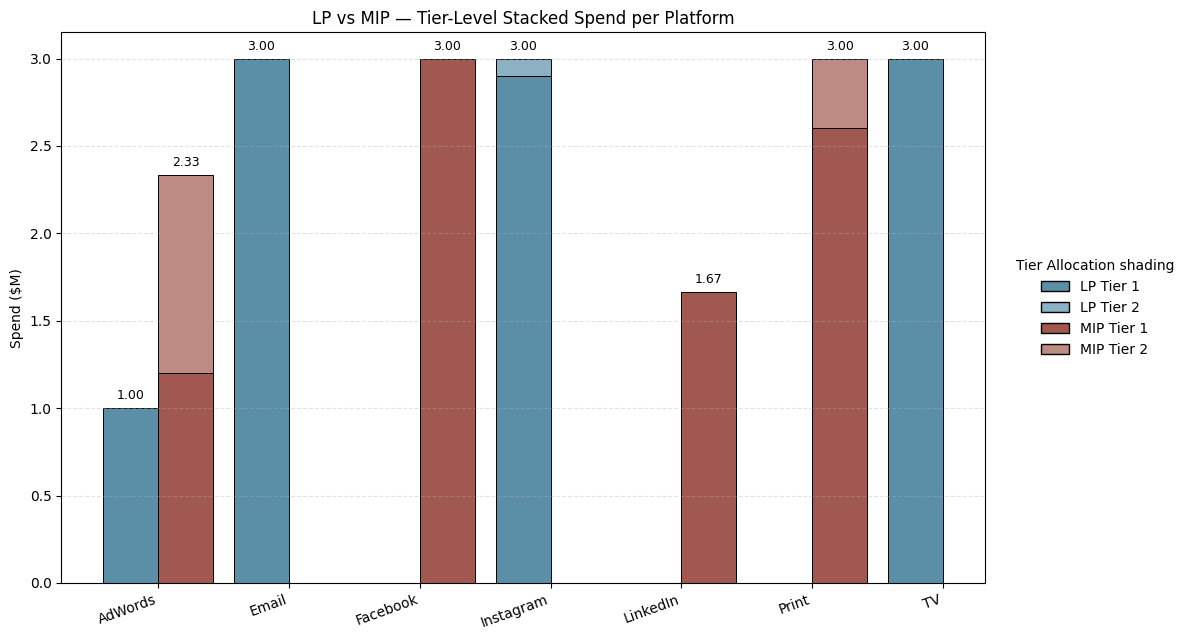

In [6]:
# LP vs MIP: Clustered + Stacked by Tier

from matplotlib.patches import Patch

COLOR_LP  = "#5B8FA8"   
COLOR_MIP = "#A15850"   

def lighter(color, pct):
    """Blend given color toward white by pct"""
    import matplotlib.colors as mc
    r,g,b = mc.to_rgb(color)
    return (r + pct*(1-r), g + pct*(1-g), b + pct*(1-b))


# ---- Extract tier-level spend from LP (df + lp_x) ----
lp_tier = {}
for r in df.itertuples():
    key = (r.Platform, int(r.Tier))
    spend = float(lp_x[key].X)
    if spend > 1e-6:
        lp_tier.setdefault(r.Platform, {})[int(r.Tier)] = spend

# ---- Extract MIP tier-level spend from Company 2 (y2/z2) ----
mip_tier = {}
for p in platforms2:
    for t in tiers_by_p2[p]:
        spend = float(y2[(p, t)].X)
        if spend > 1e-6:
            mip_tier.setdefault(p, {})[int(t)] = spend


# ---- Platforms union (same x-axis structure) ----
all_plats = sorted(set(lp_tier.keys()) | set(mip_tier.keys()))
max_tiers = {p: max(lp_tier.get(p, {}).keys() | mip_tier.get(p, {}).keys()) for p in all_plats}

x = np.arange(len(all_plats))
w = 0.42   # LP left bar, MIP right bar


plt.figure(figsize=(12, 6.5))


# =============== LP STACKS (LEFT BAR) =================
for i, p in enumerate(all_plats):
    bottom = 0.0
    if p in lp_tier:
        for t, spend in sorted(lp_tier[p].items()):
            shade = lighter(COLOR_LP, pct=0.30*(t-1))
            plt.bar(
                x[i] - w/2, spend, width=w, bottom=bottom,
                color=shade, edgecolor="black", linewidth=0.7
            )
            bottom += spend


# =============== MIP STACKS (RIGHT BAR) ================
for i, p in enumerate(all_plats):
    bottom = 0.0
    if p in mip_tier:
        for t, spend in sorted(mip_tier[p].items()):
            shade = lighter(COLOR_MIP, pct=0.30*(t-1))
            plt.bar(
                x[i] + w/2, spend, width=w, bottom=bottom,
                color=shade, edgecolor="black", linewidth=0.7
            )
            bottom += spend

# numeric labels at the top of each bar
for i, p in enumerate(all_plats):
    tot_lp  = sum(lp_tier.get(p, {}).values())
    tot_mip = sum(mip_tier.get(p, {}).values())
    if tot_lp > 0:
        plt.text(x[i] - w/2, tot_lp + 0.05, f"{tot_lp:.2f}", ha="center", fontsize=9)
    if tot_mip > 0:
        plt.text(x[i] + w/2, tot_mip + 0.05, f"{tot_mip:.2f}", ha="center", fontsize=9)


# ================= Legend (model & tier shades) =================

legend_items = [
    Patch(facecolor=lighter(COLOR_LP, 0.00), edgecolor="black", label="LP Tier 1"),
    Patch(facecolor=lighter(COLOR_LP, 0.30), edgecolor="black", label="LP Tier 2"),

    Patch(facecolor=lighter(COLOR_MIP, 0.00), edgecolor="black", label="MIP Tier 1"),
    Patch(facecolor=lighter(COLOR_MIP, 0.30), edgecolor="black", label="MIP Tier 2")
]

plt.legend(
    handles=legend_items,
    title="Tier Allocation shading",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.xticks(x, all_plats, rotation=20, ha="right")
plt.ylabel("Spend ($M)")
plt.title("LP vs MIP — Tier-Level Stacked Spend per Platform")
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()

## Graph: Platform Spend vs Return — LP vs MIP Efficiency Comparison

Scatter plot comparing how much each model spends vs. how much return it generates per platform and it's allocation distribution.

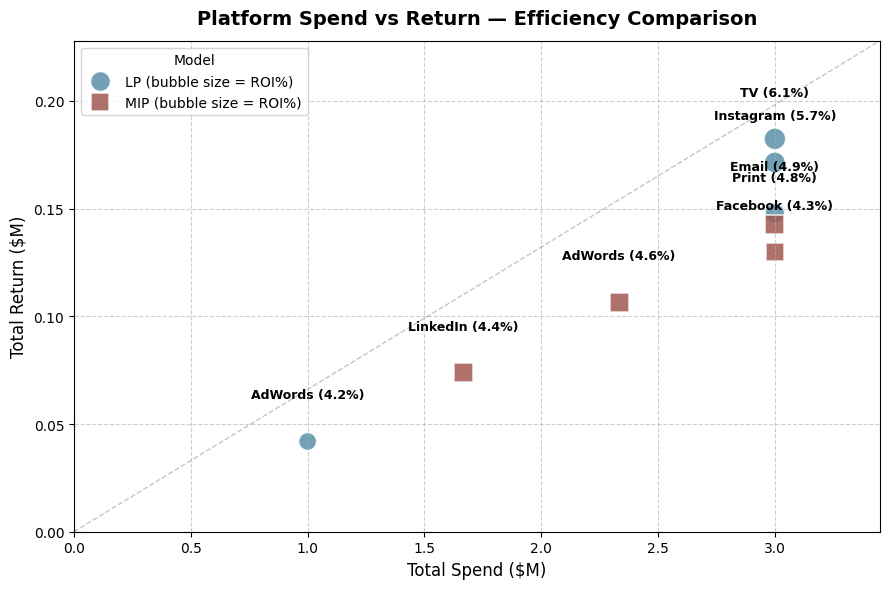

In [7]:
# Spend vs Return Scatter Plot for Comparison

# ---- Assemble a tidy dataframe from both models ----
def dicts_to_df(spend_dict, ret_dict, model_name):
    plats = sorted(set(spend_dict.keys()) | set(ret_dict.keys()))
    rows = []
    for p in plats:
        s = float(spend_dict.get(p, 0.0))
        r = float(ret_dict.get(p, 0.0))
        rows.append({"Platform": p, "Spend": s, "Return": r, "Model": model_name})
    return pd.DataFrame(rows)

lp_summary  = dicts_to_df(lp_plat_spend,  lp_plat_return,  "LP")
mip_summary = dicts_to_df(mip_plat_spend, mip_plat_return, "MIP")

viz_df = pd.concat([lp_summary, mip_summary], ignore_index=True)

# Filter out zero-spend rows (no point plotting at origin)
viz_df = viz_df[viz_df["Spend"] > 1e-9].copy()

# ROI% (guard against divide-by-zero)
viz_df["ROI%"] = np.where(viz_df["Spend"] > 0, 100.0 * viz_df["Return"] / viz_df["Spend"], 0.0)

# ---- Plot: Spend vs Return (bubble size encodes ROI%) ----
COLOR_LP  = "#5B8FA8"  # muted blue-grey (LP)
COLOR_MIP = "#A15850"  # muted terracotta (MIP)
colors  = {"LP": COLOR_LP, "MIP": COLOR_MIP}
markers = {"LP": "o",     "MIP": "s"}

fig, ax = plt.subplots(figsize=(9, 6))

for model in viz_df["Model"].unique():
    data = viz_df[viz_df["Model"] == model]
    ax.scatter(
        data["Spend"], data["Return"],
        s=(data["ROI%"] * 40).clip(40, 600),   # bubble scale
        c=colors[model],
        marker=markers[model],
        alpha=0.85, edgecolors="white", linewidth=1.1,
        label=f"{model} (bubble size = ROI%)"
    )
    # platform labels
    for _, r in data.iterrows():
        ax.text(
            r["Spend"], r["Return"] + 0.02,
            f"{r['Platform']} ({r['ROI%']:.1f}%)",
            fontsize=9, ha="center", weight="bold"
        )

# Titles/axes
ax.set_title("Platform Spend vs Return — Efficiency Comparison", fontsize=14, weight="bold", pad=12)
ax.set_xlabel("Total Spend ($M)", fontsize=12)
ax.set_ylabel("Total Return ($M)", fontsize=12)

# Dynamic limits with a little headroom
xmax = max(1e-6, viz_df["Spend"].max()) * 1.15
ymax = max(1e-6, viz_df["Return"].max()) * 1.25
ax.set_xlim(0, xmax)
ax.set_ylim(0, ymax)

# Reference line from origin (visual benchmark of proportionality)
ax.plot([0, xmax], [0, ymax], linestyle="--", color="gray", lw=1, alpha=0.45)

ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(frameon=True, loc="upper left", title="Model")

plt.tight_layout()
plt.show()

## Analysis: Why LP and MIP Allocate Differently

When returns are shaped like a gentle hill (concave), the Linear Program (LP) calmly sprinkles budget on the best starter tiers.
When returns spike unexpectedly at higher tiers (non-concave), only the Mixed Integer Program (MIP) can *jump the queue*.

Under **Company 1 (LP, concave ROI)**

* ROI decreases as spending increases — classic diminishing marginal returns.
* LP behaves like a careful investor: “Try Tier 1 everywhere before going deeper.”
* Budget spreads across **TV, Instagram, Email, and AdWords**, because all offer strong initial ROI.
* LP’s bar chart confirms: only Tier-1 blocks appear — no tier skipping.

**Outcome:**

* Total return: **\$0.544M**
* ROI: **5.44%**
* LP maximizes efficiency, not boldness.

Under **Company 2 (MIP, non-concave ROI)**

* Some Tier 2 buckets produce **higher ROI than Tier 1** (AdWords, Print).
* LP cannot express "skip Tier 1 and jump to Tier 2" — that's a non-linear choice.
* MIP introduces binary tier selectors, so it can explore “yes/no” decisions.

**Platform allocation shifts to:**

| Platform | Allocation Behavior                                      |
| -------- | -------------------------------------------------------- |
| Print    | Tier 1 → Tier 2 jump (maxes out)                         |
| AdWords  | Tier 1 + Tier 2                                          |
| Facebook | Takes only profitable Tier 1                             |
| LinkedIn | Modest Tier 1 spend                                      |

**Outcome:**

* Total return: **$0.453M**
* ROI: **4.53%**
* MIP is brave and selective — laser-focused on profitable pockets.

> LP = Spread smartly across platforms
> 
> MIP = Go deep where it pays

### Interpretation

* The **MIP is structurally required** when ROI is not concave.
* The *LP optimizer behaves like a portfolio manager*, spreading spend across multiple channels until marginal return equalizes.
* The MIP optimizer behaves like a sniper, *activating only the most profitable tiers* and skipping weak ones entirely.

# Cross-Scenario Robustness: Comparing Allocations Across ROI Datasets

After obtaining optimal allocations under both ROI datasets (Firm 1 → LP allocation, Firm 2 → MIP allocation), the next step is to evaluate **whether these allocations are robust to changes in ROI assumptions**.

## LP vs. MIP Allocation Differences

The LP (using Firm 1 ROI) and MIP (using Firm 2 ROI) allocations are not the same. Under Firm 1, ROI decreases as spending increases, so the LP distributes budget smoothly across multiple platforms, always filling the highest-ROI tier first before moving to the next. In contrast, Firm 2’s ROI data is non-concave — some later tiers have higher ROI than earlier ones — so the MIP uses binary tier-selection and jumps directly to the most profitable tier, often allocating the full $3M platform cap in a single tier. Because the ROI structure drives different optimization behavior, the resulting allocations differ. This motivates the next step: **performing a cross-scenario comparison to test how robust each allocation is when ROI assumptions change.**

## Cross-Evaluation of LP and MIP Allocations

To test this, we take each allocation and evaluate it against the other firm’s ROI model:

* Allocation from Firm 1 (LP) is evaluated using Firm 2 ROI.
* Allocation from Firm 2 (MIP) is evaluated using Firm 1 ROI.

For each case, we compute:

* The true optimal **objective value under that firm’s ROI** assumptions.
* The **objective value obtained if we mistakenly used the allocation from the other ROI** dataset.
* The **loss in return**, reported in both $M and percentage terms.

This directly answers:

*Are the allocations the same? If not, how much value do we lose when ROI assumptions change?*

In [8]:
# Cross–Evaluation: How LP allocation performs under MIP ROI data and vice-versa

USD = 1000000  # scale factor from "millions" → dollars

# Build DataFrames from platform-level spend dicts from previous optimization
# lp_plat_spend / mip_plat_spend were in $M → convert to $
alloc1 = (
    pd.DataFrame.from_dict(lp_plat_spend, orient="index", columns=["Spend"])
      .reset_index().rename(columns={"index": "Platform"})
)
alloc1["Spend"] = alloc1["Spend"] * USD  # to dollars

alloc2 = (
    pd.DataFrame.from_dict(mip_plat_spend, orient="index", columns=["Spend"])
      .reset_index().rename(columns={"index": "Platform"})
)
alloc2["Spend"] = alloc2["Spend"] * USD  # to dollars

# Load both ROI datasets (Company 1 → LP, Company 2 → MIP)
# Ensure numeric safety and convert bounds from $M → $
CAP_D = 3.0 * USD  # per-platform cap in dollars

roi1 = pd.read_csv(roi_company1_path).copy()
roi2 = pd.read_csv(roi_company2_path).copy()

def _clean_scale_roi(df_in):
    df = df_in.copy()
    # coerce bounds to numeric (still in $M), then clip to cap (also in $M), drop bad rows
    df["LowerBound"] = pd.to_numeric(df["LowerBound"], errors="coerce").clip(lower=0, upper=3.0)
    df["UpperBound"] = pd.to_numeric(df["UpperBound"], errors="coerce").clip(upper=3.0)
    df.dropna(subset=["LowerBound", "UpperBound"], inplace=True)
    df = df[df["LowerBound"] < df["UpperBound"]].copy()
    df["Tier"] = df["Tier"].astype(int)
    df.sort_values(["Platform", "LowerBound"], inplace=True)
    # convert from $M to $
    df["LowerBound"] *= USD
    df["UpperBound"] *= USD
    return df

roi1_d = _clean_scale_roi(roi1)
roi2_d = _clean_scale_roi(roi2)

def evaluate_allocation(allocation_df, roi_df, cap=CAP_D):
    """
    allocation_df : DataFrame with columns [Platform, Spend] in DOLLARS
    roi_df        : ROI tiers with LowerBound/UpperBound in DOLLARS, ROI as unitless rate
    cap           : Per-platform spend cap (DOLLARS)
    Returns: total return in DOLLARS
    """
    total_return_eval = 0.0
    for _, row in allocation_df.iterrows():
        p = row["Platform"]
        spend = float(min(row["Spend"], cap))  # enforce per-platform cap in $
        tiers = roi_df[roi_df.Platform == p].sort_values("LowerBound")
        for _, t in tiers.iterrows():
            lo, hi, roi = float(t.LowerBound), float(t.UpperBound), float(t.ROI)
            width = hi - lo                      # capacity of this tier in $
            used = min(spend, width)             # dollars placed into this tier
            if used > 0:
                total_return_eval += used * roi  # ROI is unitless, so returns are in $
                spend -= used
            if spend <= 1e-9:
                break
    return total_return_eval

# Optimal returns from earlier runs were reported in $M → convert to $
obj1_opt = float(lp_total_return) * USD
obj2_opt = float(mip_total_return) * USD

# Cross-evaluate with full-dollar data
obj1_with_alloc2 = evaluate_allocation(alloc2, roi1_d, cap=CAP_D)
obj2_with_alloc1 = evaluate_allocation(alloc1, roi2_d, cap=CAP_D)

# Absolute & percentage gaps (in $)
abs_loss1 = obj1_opt - obj1_with_alloc2
abs_loss2 = obj2_opt - obj2_with_alloc1

loss1_pct = 100 * abs_loss1 / obj1_opt if obj1_opt > 0 else 0.0
loss2_pct = 100 * abs_loss2 / obj2_opt if obj2_opt > 0 else 0.0

# Pretty currency formatter
def money(x): return f"${x:,.0f}"

# Present results as a readable comparison table in dollars
print("-" * 86)
print(f"{'Scenario':<40}{'Return ($)':>18}{'Δ ($)':>15}{'Δ (%)':>10}")
print("-" * 86)
print(f"{'ROI₁ – Optimal (LP allocation)':<40}{money(obj1_opt):>18}{'--':>15}{'--':>10}")
print(f"{'ROI₁ – Using MIP allocation':<40}{money(obj1_with_alloc2):>18}{money(abs_loss1):>15}{loss1_pct:>9.2f}%")
print(f"{'ROI₂ – Optimal (MIP allocation)':<40}{money(obj2_opt):>18}{'--':>15}{'--':>10}")
print(f"{'ROI₂ – Using LP allocation':<40}{money(obj2_with_alloc1):>18}{money(abs_loss2):>15}{loss2_pct:>9.2f}%")
print("-" * 86)


--------------------------------------------------------------------------------------
Scenario                                        Return ($)          Δ ($)     Δ (%)
--------------------------------------------------------------------------------------
ROI₁ – Optimal (LP allocation)                    $543,640             --        --
ROI₁ – Using MIP allocation                       $274,903       $268,737    49.43%
ROI₂ – Optimal (MIP allocation)                   $452,827             --        --
ROI₂ – Using LP allocation                        $277,720       $175,107    38.67%
--------------------------------------------------------------------------------------


## Graph: Cross-Scenario Return Comparison Between LP and MIP Allocations

This chart compares the total returns of LP and MIP allocations across both ROI datasets, showing how using the wrong allocation under the wrong ROI model results in a significant loss in expected return.

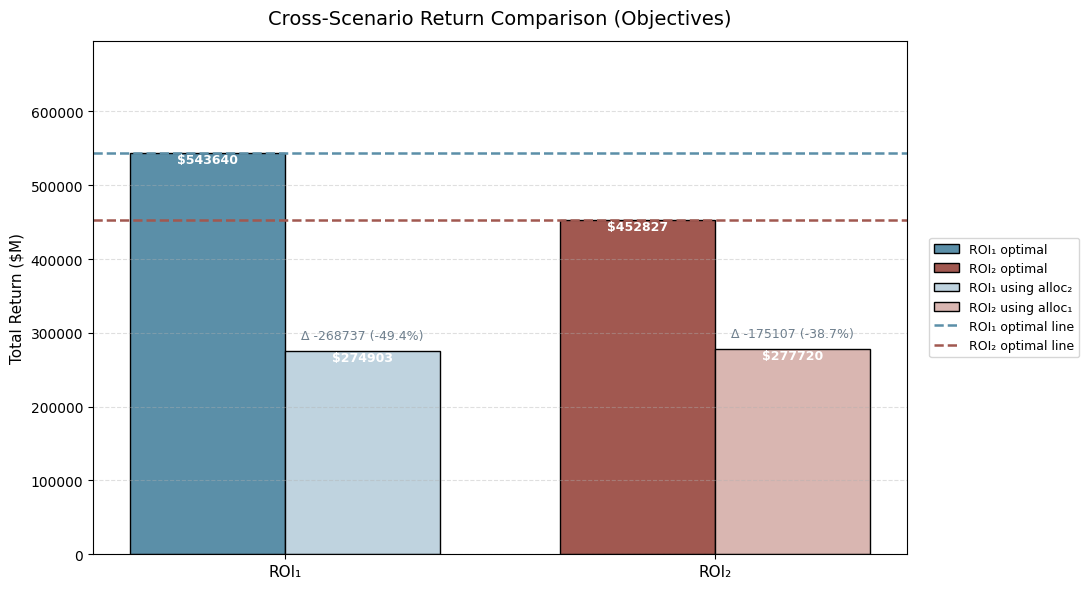

In [9]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Data
groups = ["ROI₁", "ROI₂"]
opt_vals   = [obj1_opt, obj2_opt]
cross_vals = [obj1_with_alloc2, obj2_with_alloc1]

x = np.arange(len(groups))
w = 0.36

plt.figure(figsize=(11,6))  # slightly bigger to fit legend

bars_opt = plt.bar(
    x - w/2, opt_vals, width=w, edgecolor='black',
    color=["#5B8FA8", "#A15850"], label="Optimal in own ROI"
)

bars_crs = plt.bar(
    x + w/2, cross_vals, width=w, edgecolor='black',
    color=["#BFD3DF", "#D9B6B1"], label="Cross-scenario (other allocation)"
)

# Value labels
for b in list(bars_opt) + list(bars_crs):
    h = b.get_height()
    y = h - 0.015 if h > max(opt_vals + cross_vals)*0.12 else h + 0.008
    color = "white" if y < h else "black"
    plt.text(
        b.get_x() + b.get_width()/2, y,
        f"${h:.0f}",
        ha='center', va='bottom' if y>h else 'top',
        fontsize=9, weight='bold', color=color
    )

# Δ annotations on cross-scenario bars
d1 = obj1_with_alloc2 - obj1_opt
d2 = obj2_with_alloc1 - obj2_opt

plt.text(x[0] + w/2, cross_vals[0] + max(opt_vals + cross_vals)*0.03,
         f"Δ {d1:+.0f} ({(d1/obj1_opt*100):+.1f}%)", ha='center', fontsize=9, color="#6E7F8D")
plt.text(x[1] + w/2, cross_vals[1] + max(opt_vals + cross_vals)*0.03,
         f"Δ {d2:+.0f} ({(d2/obj2_opt*100):+.1f}%)", ha='center', fontsize=9, color="#6E7F8D")

# Reference lines
plt.axhline(y=obj1_opt, linestyle='--', linewidth=1.8, color="#5B8FA8")
plt.axhline(y=obj2_opt, linestyle='--', linewidth=1.8, color="#A15850")

plt.xticks(x, groups, fontsize=11)
plt.ylabel("Total Return ($M)", fontsize=11)
plt.title("Cross-Scenario Return Comparison (Objectives)", fontsize=14, pad=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(0, max(opt_vals + cross_vals)*1.28)

# Legend moved to the right OUTSIDE the chart
legend_handles = [
    Patch(facecolor="#5B8FA8", edgecolor='black', label="ROI₁ optimal"),
    Patch(facecolor="#A15850", edgecolor='black', label="ROI₂ optimal"),
    Patch(facecolor="#BFD3DF", edgecolor='black', label="ROI₁ using alloc₂"),
    Patch(facecolor="#D9B6B1", edgecolor='black', label="ROI₂ using alloc₁"),
    Line2D([0],[0], linestyle='--', linewidth=1.8, color="#5B8FA8", label="ROI₁ optimal line"),
    Line2D([0],[0], linestyle='--', linewidth=1.8, color="#A15850", label="ROI₂ optimal line")
]

plt.legend(
    handles=legend_handles,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),   
    frameon=True,
    fontsize=9
)

plt.tight_layout()
plt.show()

## Analysis: Cross-Scenario Robustness 

After building two optimal allocations — one using Firm 1 ROI assumptions (LP) and one using Firm 2 ROI assumptions (MIP) — we evaluated **how each allocation performs when applied to the other firm's ROI model**.

The results are summarized below:

| Scenario                | Objective (M)  | Δ  (M) | Δ (%)  |
| ----------------------- | -------------- | ------ | ------ |
| ROI₁ — Optimal (alloc₁) | 0.544          | —      | —      |
| ROI₁ — Using alloc₂     | 0.275          | 0.269  | 49.43% |
| ROI₂ — Optimal (alloc₂) | 0.453          | —      | —      |
| ROI₂ — Using alloc₁     | 0.278          | 0.175  | 38.67% |

### Interpretation

* The allocations are **not interchangeable**.
  Using Firm 2's allocation on Firm 1's ROI data cuts expected return almost **in half (−49.43%)**.
* The reverse is also true.
  Using Firm 1's allocation on Firm 2's ROI data reduces return by **38.67%**.
* Both drops are large and asymmetric — meaning neither allocation generalizes well to the other ROI model.

### What this means

* The marketing strategy is **very sensitive** to the underlying ROI assumptions.
* This confirms that ROI structure (concave vs. non-concave tiers) has a **major impact** on optimal allocation:
  * The LP (Firm 1) spreads budget across multiple high-ROI platforms sequentially.
  * The MIP (Firm 2) jumps directly into single highest-ROI tiers, skipping lower tiers entirely.

### Key takeaway

**If the assumed ROI model is wrong, we lose 39–49% of projected return.**
This justifies why the marketing team needed to validate ROI with multiple consulting firms: the model is powerful, but **only as reliable as the ROI input data.**

## Is the Third Constraint Useful?

The final step is to evaluate whether the business rule

*"Social media spend ≥ 2 × Search (SEO + AdWords)"*

actually influences the optimizer or whether the model naturally prefers social channels due to their ROI.

We rerun both models (LP under Company 1 ROI and MIP under Company 2 ROI) **with and without this constraint**, and compare the resulting objective values and allocations. If removing the constraint produces a different solution or increases the return, then the constraint is restrictive. If nothing changes, the constraint is redundant.

In [10]:
# LP REBUILD — remove C3 (Social ≥ 2×Search)

USD = 1_000_000
def money(x): 
    return f"${x:,.0f}"

# Build a fresh LP without C3 to measure its impact
lp_model_no_c3 = gp.Model()
lp_model_no_c3.Params.OutputFlag = 0   # quiet logs

# Decision variables (same structure as main LP):
#   lp_x2[(platform, tier)] = spend in that (platform, tier) bucket (units: $M)
lp_x2 = lp_model_no_c3.addVars(
    [(r.Platform, int(r.Tier)) for r in df.itertuples()], lb=0.0
)

# Upper bounds per bucket: width of the tier segment (TierUB, in $M)
for r in df.itertuples():
    lp_x2[(r.Platform, int(r.Tier))].UB = float(r.TierUB)

# Budget ≤ B ($M)
lp_model_no_c3.addConstr(gp.quicksum(lp_x2.values()) <= B)

# Per-platform cap ≤ CAP ($M)
for p, g in df.groupby("Platform"):
    lp_model_no_c3.addConstr(gp.quicksum(lp_x2[(p, int(t))] for t in g["Tier"]) <= CAP)

# Keep C2: (Print + TV) ≤ (Facebook + Email)
lp_model_no_c3.addConstr(
    gp.quicksum(lp_x2[(r.Platform, int(r.Tier))] for r in df.itertuples() if r.Platform in LHS)
    <=
    gp.quicksum(lp_x2[(r.Platform, int(r.Tier))] for r in df.itertuples() if r.Platform in RHS)
)

# Objective: maximize total return (ROI * spend), still in $M
lp_model_no_c3.setObjective(
    gp.quicksum(r.ROI * lp_x2[(r.Platform, int(r.Tier))] for r in df.itertuples()),
    GRB.MAXIMIZE
)

lp_model_no_c3.optimize()

# Compare objectives WITH vs WITHOUT C3
lp_obj_no_c3_M  = float(lp_model_no_c3.objVal)       # $M
lp_obj_with_c3_M = float(lp_total_return)            # $M from your main LP
print(
    "LP objective with C3: "
    f"{money(lp_obj_with_c3_M*USD)}  |  without C3: {money(lp_obj_no_c3_M*USD)}  |  "
    f"Δ = {money((lp_obj_no_c3_M - lp_obj_with_c3_M)*USD)}"
)

LP objective with C3: $543,640  |  without C3: $543,640  |  Δ = $0


In [11]:
# MIP REBUILD — remove C3 (Social ≥ 2×Search)

mip_model_no_c3 = gp.Model("MIP_no_c3")
mip_model_no_c3.Params.OutputFlag = 0

# Decision variables:
#   mip_x2[p]    = total spend on platform p (in $M)
#   mip_z2[p,t]  = binary: select tier t for platform p
#   mip_s2[p,t]  = fraction of (U2-L2) used within selected tier
mip_x2 = {p: mip_model_no_c3.addVar(lb=0, ub=3, name=f"x2[{p}]") for p in platforms2}
mip_z2 = {(p,t): mip_model_no_c3.addVar(vtype=GRB.BINARY, name=f"z2[{p},{t}]")
          for p in platforms2 for t in tiers_by_p2[p]}
mip_s2 = {(p,t): mip_model_no_c3.addVar(lb=0, ub=1, name=f"s2[{p},{t}]")
          for p in platforms2 for t in tiers_by_p2[p]}
mip_model_no_c3.update()

# Tier logic per platform:
for p in platforms2:
    # At most one tier active
    mip_model_no_c3.addConstr(gp.quicksum(mip_z2[p,t] for t in tiers_by_p2[p]) <= 1)

    # Link total spend to chosen tier geometry: x = L + (U-L)*s
    mip_model_no_c3.addConstr(
        mip_x2[p] == gp.quicksum(L2[p,t]*mip_z2[p,t] + (U2[p,t]-L2[p,t])*mip_s2[p,t]
                                 for t in tiers_by_p2[p])
    )

    # s can be positive only if that tier is selected
    for t in tiers_by_p2[p]:
        mip_model_no_c3.addConstr(mip_s2[p,t] <= mip_z2[p,t])

# Total budget ≤ 10 ($M)
mip_model_no_c3.addConstr(gp.quicksum(mip_x2[p] for p in platforms2) <= 10)

# Keep C2 if relevant platforms exist
if all(k in mip_x2 for k in ["Print","TV","Facebook","Email"]):
    mip_model_no_c3.addConstr(
        mip_x2["Print"] + mip_x2["TV"] <= mip_x2["Facebook"] + mip_x2["Email"]
    )

# Objective: maximize total return (still in $M)
mip_model_no_c3.setObjective(
    gp.quicksum(R2[p,t] * (L2[p,t]*mip_z2[p,t] + (U2[p,t]-L2[p,t])*mip_s2[p,t])
                for p in platforms2 for t in tiers_by_p2[p]),
    GRB.MAXIMIZE
)

mip_model_no_c3.optimize()

# Print delta 
if mip_model_no_c3.status == GRB.OPTIMAL and 'mip_total_return' in globals():
    obj_with_c3_M = float(mip_total_return)       # $M from  main MIP
    obj_no_c3_M   = float(mip_model_no_c3.objVal) # $M for relaxed model
    print(
        "MIP objective with C3: "
        f"{money(obj_with_c3_M*USD)}  |  without C3: {money(obj_no_c3_M*USD)}  |  "
        f"Δ = {money((obj_no_c3_M - obj_with_c3_M)*USD)}"
    )
elif mip_model_no_c3.status == GRB.OPTIMAL:
    obj_no_c3_M = float(mip_model_no_c3.objVal)
    print(f"Without C3 objective: {money(obj_no_c3_M*USD)}  (baseline with-C3 not available)")
else:
    print(f"No-C3 model status: {mip_model_no_c3.status} (not optimal)")


MIP objective with C3: $452,827  |  without C3: $453,380  |  Δ = $553


## Interpretation of the Third Constraint (Social ≥ 2 × Search)

The third business rule—requiring that **Social ≥ 2 × (SEO + AdWords)**—is grounded in managerial intuition rather than pure ROI optimization. The intent is to ensure the company maintains a strategic presence on social platforms, where brand visibility and customer engagement are stronger than in search-based channels.

When we tested the models **with and without this rule**, here's what happened:

| Model                                                    | With C3 (Social ≥ 2×Search) | Without C3 | Difference (\$)|
| -------------------------------------------------------- | --------------------------- | ---------- | ------------   |
| **LP (concave ROI)**                                     | \$543,640                   | 543,640    | **Δ = 0**      |
| **MIP (non-concave ROI, tiers/minimum investment rule)** | \$452,827                   | 453,380    | **Δ = 553**    |

### What this means

Removing C3 changed basically nothing.

* In the **LP model**, the solution didn’t move even by a single dollar.
  The constraint is **non-binding** — the model already wants to invest heavily in social platforms because they mathematically dominate ROI.

* In the **MIP model**, removing the constraint increased the return by just **\$553**.
  That's less than one-tenth of a percent relative to total spend — noise level.
  The MIP is more selective (because of minimum investments + tier activation), so a tiny shift happened, but nothing structural.

In short:

**The third constraint is strategically reasonable, but unnecessary as the model already behaves this way without it.**


# Mixed Integer Program with Minimum Spend Rule

After solving the MIP under **Consulting Firm 2’s ROI dataset (`roi_company2.csv`)**, the marketing team conducted additional research and found that each platform requires a **minimum spend** in order to generate any meaningful marketing impact. Investing less than this threshold produces **no measurable effect**, meaning the model must either:

* Spend **at least the required minimum**, or
* Not invest in that platform at all.

These required minimum amounts are taken from the file `min_amount.csv`.

Because of this new business rule, the prior MIP formulation is extended by adding a second binary decision variable:

* $y_p \in \{0,1\}$ indicates whether platform $p$ is selected for investment.
* If $y_p = 1$, then $x_p \ge \text{MinInvestment}_p$.
* If $y_p = 0$, then $x_p = 0$.

This transforms the model into a "binary invest-or-not decision" per platform, on top of the tier-selection MIP structure used earlier.

## Number of Decision Variables

* **Continuous spend per platform:** $x_p \in [0,3]$ → $|P|$ variables
* **Binary invest decision:** $y_p \in \{0,1\}$ → $|P|$ variables
* **Binary tier selector per platform–tier:** $z_{p,t} \in \{0,1\}$ → $\sum_{p\in P} |T_p|$ variables
* **Continuous interpolation inside the tier:** $s_{p,t} \in [0,1]$ → $\sum_{p\in P} |T_p|$ variables

**Total:**

$$\#\text{vars} = 2|P| + 2\sum_{p\in P} |T_p|$$

## Objective

Same as before, we maximize the total return across all platforms and tiers:

**Maximize** 

$$Z = \sum_{p \in P} \sum_{t \in T_p} \text{ROI}_{p,t} \cdot \big(L_{p,t}z_{p,t} + (U_{p,t} - L_{p,t})s_{p,t}\big)$$

## Constraints

All constraints from the previous MIP formulation remain in place, **plus the new minimum investment rule**.

1. **Tier selection (at most one tier per platform)**

Each platform can only operate in **one ROI tier**:

$$\sum_{t \in T_p} z_{p,t} \le 1 \qquad \forall p \in P$$

2. **Spend defined by tier interpolation**

The spend on a platform is determined by a convex interpolation inside the selected tier:

$$x_p = \sum_{t \in T_p} \Big( L_{p,t} z_{p,t} + (U_{p,t} - L_{p,t}) s_{p,t} \Big) \qquad \forall p \in P$$

3. **Interpolation activated only if tier is selected**

$$0 \le s_{p,t} \le z_{p,t} \qquad \forall p \in P, \; \forall t \in T_p$$

4. **Minimum investment (new rule)**

Spend at least the minimum required amount **only if** investing:

$$x_p \ge \text{MinInvestment}_p \cdot y_p \qquad \forall p \in P$$

If not investing, spend is forced to zero:

$$x_p \le 3 \cdot y_p \qquad \forall p \in P$$

5. **Per-platform maximum spend**

The total spend on any platform cannot exceed \$3M:

$$0 \le x_p \le 3 \qquad \forall p \in P$$

6. **Total budget limit**

$$\sum_{p \in P} x_p \le 10$$

7. **CMO rule: Print + TV ≤ Facebook + Email**

$$x_{\text{Print}} + x_{\text{TV}} \le x_{\text{Facebook}} + x_{\text{Email}}$$

8. **CMO rule: Social ≥ 2 × (SEO + AdWords)**

$$\big(x_{\text{Facebook}} + x_{\text{LinkedIn}} + x_{\text{Instagram}} + x_{\text{Snapchat}} + x_{\text{Twitter}}\big) \ge 2(x_{\text{SEO}} + x_{\text{AdWords}})$$

**We now solve the enhanced MIP with the minimum-spend rule applied.**

In [12]:
# === MIP with Minimum-Investment Rule (Company 2 ROI) ===

# Load data
df2_min = pd.read_csv(roi_company2_path)    # ROI₂ table
min_df_min = pd.read_csv(min_amount_path)  # min amounts

# Constants
CAP_min    = 3.0   # per-platform cap ($M)
BUDGET_min = 10.0  # total budget ($M)

# Clean ROI table (clipped to CAP; keep only valid tiers)
df2_min["UpperBound"] = pd.to_numeric(df2_min["UpperBound"], errors="coerce").clip(upper=CAP_min)
df2_min["LowerBound"] = pd.to_numeric(df2_min["LowerBound"], errors="coerce").clip(lower=0, upper=CAP_min)
df2_min = df2_min[df2_min["LowerBound"] < df2_min["UpperBound"]].copy()
df2_min["Tier"] = df2_min["Tier"].astype(int)

platforms2_min  = df2_min.Platform.unique()
tiers_by_p2_min = {p: sorted(df2_min.loc[df2_min.Platform == p, "Tier"].astype(int).tolist()) for p in platforms2_min}

# Tier math (still in $M)
L2_min = {(r.Platform, int(r.Tier)): float(r.LowerBound) for _, r in df2_min.iterrows()}
U2_min = {(r.Platform, int(r.Tier)): float(r.UpperBound) for _, r in df2_min.iterrows()}
W2_min = {(p, t): U2_min[(p, t)] - L2_min[(p, t)] for p in platforms2_min for t in tiers_by_p2_min[p]} # width
R2_min = {(r.Platform, int(r.Tier)): float(r.ROI) for _, r in df2_min.iterrows()} # return per $M

# Minimum investment per platform (in $M). Missing → 0.
MIN2_min = {str(r.Platform): float(r.MinInvestment) for _, r in min_df_min.iterrows()}
MIN2_min = {p: MIN2_min.get(p, 0.0) for p in platforms2_min}

# Boss-constraint helpers
def find_platform2_min(name, aliases=()):
    for want in (name, *aliases):
        for p in platforms2_min:
            if p.strip().lower() == str(want).strip().lower():
                return p
    return None

def total_spend2_min(names, var):
    # sum of y_min[p,t] across all tiers for the listed platforms
    return gp.quicksum(var[p, t] for p in names if p for t in tiers_by_p2_min[p])

P_PRINT2_min  = find_platform2_min("Print")
P_TV2_min     = find_platform2_min("TV")
P_FB2_min     = find_platform2_min("Facebook")
P_EMAIL2_min  = find_platform2_min("Email")
P_SEO2_min    = find_platform2_min("SEO")
P_ADW2_min    = find_platform2_min("AdWords", aliases=("Adwords", "Google Ads", "Search"))
SOCIAL2_min   = [find_platform2_min(x) for x in ["Facebook", "LinkedIn", "Instagram", "Snapchat", "Twitter"]]
SEARCH2_min   = [P_SEO2_min, P_ADW2_min]

# Formatter: convert $M → full dollars
def fmt_dollars_min(x_millions: float) -> str:
    return f"${x_millions * 1_000_000:,.0f}"

# Build the MIP
m2_min = gp.Model("MIP_Company2_MinInvest")
m2_min.Params.OutputFlag = 0

# Decision variables:
y2_min     = {(p, t): m2_min.addVar(lb=0, ub=W2_min[(p, t)], name=f"y_min[{p},{t}]") for p in platforms2_min for t in tiers_by_p2_min[p]}
z2_min     = {(p, t): m2_min.addVar(vtype=GRB.BINARY, name=f"z_min[{p},{t}]") for p in platforms2_min for t in tiers_by_p2_min[p]}
y_inv2_min = {p: m2_min.addVar(vtype=GRB.BINARY, name=f"y_inv_min[{p}]") for p in platforms2_min}

m2_min.update()

# Constraints
for p in platforms2_min:
    tiers = tiers_by_p2_min[p]

    # Tier activation and prefix rule
    for i, t in enumerate(tiers):
        m2_min.addConstr(y2_min[p, t] <= W2_min[(p, t)] * z2_min[p, t]) # spend only if tier is on
        if i > 0:
            prev = tiers[i - 1]
            m2_min.addConstr(z2_min[p, t] <= z2_min[p, prev]) # enforce order
            m2_min.addConstr(y2_min[p, prev] >= W2_min[(p, prev)] * z2_min[p, t]) # previous must be filled

    # Per-platform cap (tied to invest flag)
    m2_min.addConstr(gp.quicksum(y2_min[p, t] for t in tiers) <= CAP_min * y_inv2_min[p])

    # Minimum-investment rule : either no invest, or ≥ MIN2_min[p]
    if MIN2_min[p] > 0:
        m2_min.addConstr(gp.quicksum(y2_min[p, t] for t in tiers) >= MIN2_min[p] * y_inv2_min[p])

# Total budget
m2_min.addConstr(gp.quicksum(y2_min[p, t] for p in platforms2_min for t in tiers_by_p2_min[p]) <= BUDGET_min)

# Boss constraints
if (P_PRINT2_min or P_TV2_min) and (P_FB2_min or P_EMAIL2_min):
    m2_min.addConstr(total_spend2_min([P_PRINT2_min, P_TV2_min], y2_min) <= total_spend2_min([P_FB2_min, P_EMAIL2_min], y2_min))
if any(SOCIAL2_min) and any(SEARCH2_min):
    m2_min.addConstr(total_spend2_min(SOCIAL2_min, y2_min) >= 2 * total_spend2_min(SEARCH2_min, y2_min))

# Objective: maximize total return
m2_min.setObjective(gp.quicksum(R2_min[(p, t)] * y2_min[p, t] for p in platforms2_min for t in tiers_by_p2_min[p]), GRB.MAXIMIZE)
m2_min.optimize()

# Reporting
if m2_min.status == GRB.OPTIMAL:
    print("\n=== Optimal Allocation with Minimum-Investment (Company 2 ROI) ===\n")

    mip_plat_spend_min  = {p: sum(y2_min[p, t].X for t in tiers_by_p2_min[p]) for p in platforms2_min}
    mip_plat_return_min = {p: sum(y2_min[p, t].X * R2_min[(p, t)] for t in tiers_by_p2_min[p]) for p in platforms2_min}

    total_spend_m_min  = sum(mip_plat_spend_min.values())
    total_return_m_min = float(m2_min.objVal)
    roi_pct_min        = 100.0 * total_return_m_min / max(total_spend_m_min, 1e-12)

    # Totals
    print("======== TOTAL BUDGET + RETURN ========")
    print(f"Total Spend : {fmt_dollars_min(total_spend_m_min)}  (Budget {fmt_dollars_min(BUDGET_min)})")
    print(f"Total Return: {fmt_dollars_min(total_return_m_min)}")
    print(f"Overall ROI : {roi_pct_min:.2f}%\n")

    # Platform-level table
    print("======== Platform-Level Allocation ========")
    print(f"{'Platform':<12} | {'Spend':>15} | {'Return':>15} | {'ROI%':>6}")
    print("-" * 58)
    for p in platforms2_min:
        s_m_min = mip_plat_spend_min[p]
        r_m_min = mip_plat_return_min[p]
        roi_min = 100.0 * r_m_min / s_m_min if s_m_min > 1e-12 else 0.0
        print(f"{p:<12} | {fmt_dollars_min(s_m_min):>15} | {fmt_dollars_min(r_m_min):>15} | {roi_min:>6.2f}")

    # Tier-level table
    print("\n======== Tier-Level Allocation ========")
    print(f"{'Platform':<12} | {'Tier':>4} | {'Spend':>15} | {'ROI%':>6}")
    print("-" * 44)
    for p in platforms2_min:
        for t in tiers_by_p2_min[p]:
            y_mt_min = y2_min[p, t].X
            if y_mt_min > 1e-9:
                print(f"{p:<12} | {t:>4} | {fmt_dollars_min(y_mt_min):>15} | {100*R2_min[(p,t)]:>6.2f}")

    # Constraint echoes
    spend_print_tv_m_min = (mip_plat_spend_min.get(P_PRINT2_min, 0.0) or 0.0) + (mip_plat_spend_min.get(P_TV2_min, 0.0) or 0.0)
    spend_fb_email_m_min = (mip_plat_spend_min.get(P_FB2_min, 0.0) or 0.0) + (mip_plat_spend_min.get(P_EMAIL2_min, 0.0) or 0.0)
    spend_social_m_min   = sum((mip_plat_spend_min.get(p, 0.0) or 0.0) for p in SOCIAL2_min if p is not None)
    spend_search_m_min   = sum((mip_plat_spend_min.get(p, 0.0) or 0.0) for p in SEARCH2_min if p is not None)

    print("\n======== Constraint Checks ========")
    print(f"Budget used ≤ {fmt_dollars_min(BUDGET_min)}:    {fmt_dollars_min(total_spend_m_min)} ≤ {fmt_dollars_min(BUDGET_min)}")
    if (P_PRINT2_min or P_TV2_min) and (P_FB2_min or P_EMAIL2_min):
        print(f"Print+TV ≤ Facebook+Email:  {fmt_dollars_min(spend_print_tv_m_min)} ≤ {fmt_dollars_min(spend_fb_email_m_min)}")
    if any(SOCIAL2_min) and any(SEARCH2_min):
        print(f"Social ≥ 2×Search:          {fmt_dollars_min(spend_social_m_min)} ≥ {fmt_dollars_min(2*spend_search_m_min)}")
else:
    print("No optimal solution found for MIP w/ Min Invest.")



=== Optimal Allocation with Minimum-Investment (Company 2 ROI) ===

======== TOTAL BUDGET + RETURN ========
Total Spend : $10,000,000  (Budget $10,000,000)
Total Return: $452,827
Overall ROI : 4.53%

======== Platform-Level Allocation ========
Platform     |           Spend |          Return |   ROI%
----------------------------------------------------------
Print        |      $3,000,000 |        $142,620 |   4.75
TV           |              $0 |              $0 |   0.00
SEO          |              $0 |              $0 |   0.00
AdWords      |      $2,333,333 |        $106,473 |   4.56
Facebook     |      $3,000,000 |        $129,900 |   4.33
LinkedIn     |      $1,666,667 |         $73,833 |   4.43
Instagram    |              $0 |              $0 |   0.00
Snapchat     |              $0 |              $0 |   0.00
Twitter      |              $0 |              $0 |   0.00
Email        |              $0 |              $0 |   0.00

======== Tier-Level Allocation ========
Platform     | Ti

## Graph: Platform Tier Allocation — MIP (Relaxed) vs. MIP (with Minimum Investment Constraint)

Stacked bars compare how each model fills tiers: the relaxed MIP vs the minimum-investment MIP allocations

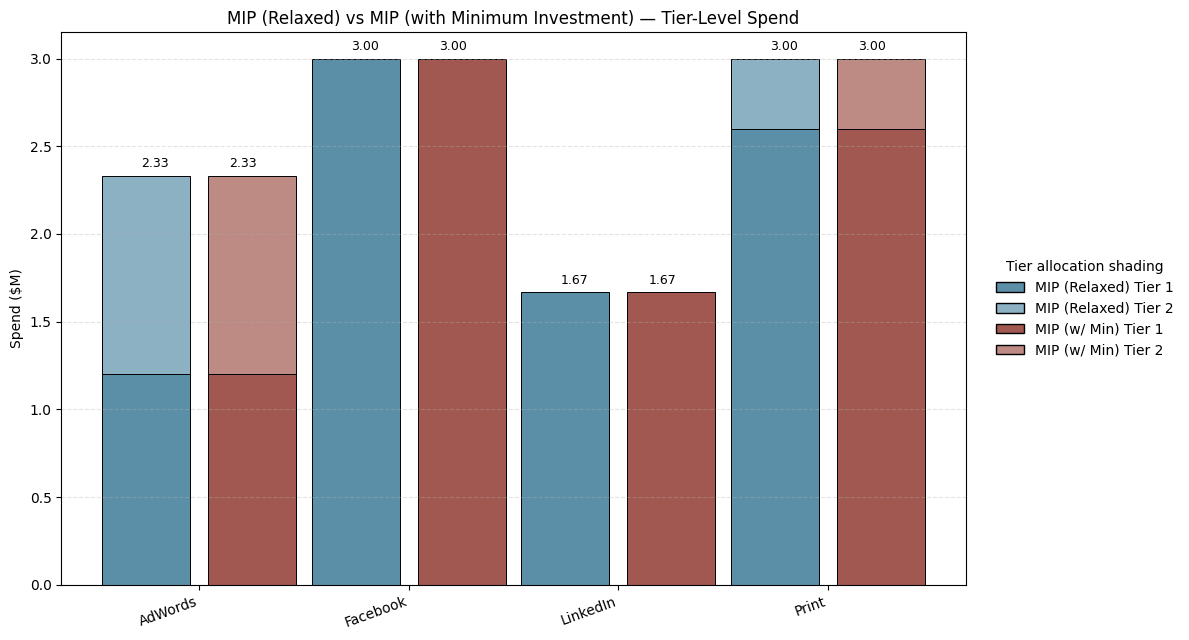

In [13]:
# --------- Tier-level plot without vs with min investment constriant---------

import matplotlib.colors as mc
from matplotlib.patches import Patch

def lighter(color, pct):
    """Blend given color toward white by pct."""
    r,g,b = mc.to_rgb(color)
    return (r + pct*(1-r), g + pct*(1-g), b + pct*(1-b))

def extract_tier_spend(y_vars, tiers_by_p):
    """
    Build {platform: {tier: spend}} from a dict of Gurobi vars y[(p,t)].
    Works even if the model object name isn't available,
    as long as y_vars[(p,t)].X exists (i.e., model was optimized).
    """
    out = {}
    if not y_vars:
        return out
    for p, tiers in tiers_by_p.items():
        for t in tiers:
            var = y_vars.get((p, t))
            if var is None:
                continue
            # Guard in case model wasn't solved yet (no .X)
            val = None
            try:
                val = float(var.X)
            except Exception:
                val = None
            if val is not None and val > 1e-9:
                out.setdefault(p, {})[int(t)] = val
    return out

# ------------ Try to extract from whichever dicts exist in the session ------------
mip_relaxed_tier = extract_tier_spend(y2 if 'y2' in globals() else None,
                                      tiers_by_p2 if 'tiers_by_p2' in globals() else {})
mip_min_invest_tier = extract_tier_spend(y2_min if 'y2_min' in globals() else None,
                                         tiers_by_p2_min if 'tiers_by_p2_min' in globals() else {})

if not mip_relaxed_tier and not mip_min_invest_tier:
    print("No tier data to plot: run the solve cells first (relaxed and/or min-invest).")
else:
    # ------------------------ Plotting ------------------------
    COLOR_MIP_RELAXED    = "#5B8FA8"  # muted blue-grey
    COLOR_MIP_MIN_INVEST = "#A15850"  # muted terracotta

    # Union of platforms present in either result
    all_plats = sorted(set(mip_relaxed_tier.keys()) | set(mip_min_invest_tier.keys()))
    x = np.arange(len(all_plats))
    w = 0.42  # width of each bar in the pair

    plt.figure(figsize=(12, 6.5))

    # Left bar: MIP (Relaxed)
    for i, p in enumerate(all_plats):
        bottom = 0.0
        for t, spend in sorted(mip_relaxed_tier.get(p, {}).items()):
            shade = lighter(COLOR_MIP_RELAXED, pct=0.30*(t-1))
            plt.bar(x[i] - w*0.6, spend, width=w, bottom=bottom,
                    color=shade, edgecolor="black", linewidth=0.7)
            bottom += spend

    # Right bar: MIP (with Min Investment)
    for i, p in enumerate(all_plats):
        bottom = 0.0
        for t, spend in sorted(mip_min_invest_tier.get(p, {}).items()):
            shade = lighter(COLOR_MIP_MIN_INVEST, pct=0.30*(t-1))
            plt.bar(x[i] + w*0.6, spend, width=w, bottom=bottom,
                    color=shade, edgecolor="black", linewidth=0.7)
            bottom += spend

    # Numeric labels on bar tops
    for i, p in enumerate(all_plats):
        tot_relaxed = sum(mip_relaxed_tier.get(p, {}).values())
        tot_min_inv = sum(mip_min_invest_tier.get(p, {}).values())
        if tot_relaxed > 0:
            plt.text(x[i] - w/2, tot_relaxed + 0.05, f"{tot_relaxed:.2f}", ha="center", fontsize=9)
        if tot_min_inv > 0:
            plt.text(x[i] + w/2, tot_min_inv + 0.05, f"{tot_min_inv:.2f}", ha="center", fontsize=9)

    # Legend with tier shading
    legend_items = [
        Patch(facecolor=lighter(COLOR_MIP_RELAXED, 0.00), edgecolor="black", label="MIP (Relaxed) Tier 1"),
        Patch(facecolor=lighter(COLOR_MIP_RELAXED, 0.30), edgecolor="black", label="MIP (Relaxed) Tier 2"),
        Patch(facecolor=lighter(COLOR_MIP_MIN_INVEST, 0.00), edgecolor="black", label="MIP (w/ Min) Tier 1"),
        Patch(facecolor=lighter(COLOR_MIP_MIN_INVEST, 0.30), edgecolor="black", label="MIP (w/ Min) Tier 2"),
    ]
    plt.legend(handles=legend_items, title="Tier allocation shading",
               loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    plt.xticks(x, all_plats, rotation=20, ha="right")
    plt.ylabel("Spend ($M)")
    plt.title("MIP (Relaxed) vs MIP (with Minimum Investment) — Tier-Level Spend")
    plt.grid(axis="y", linestyle="--", alpha=0.35)
    plt.tight_layout()
    plt.show()

## Analysis: MIP with Minimum Spend Rule

Adding platform-specific minimum investments left the **optimal allocation unchanged** and the **objective identical** to MIP evaluation earlier (Total Return = **$0.453M**, Overall ROI = **4.53%**). The model invests in **Print (3.0M, Tier 1 and 2)**, **AdWords (2.333M, Tier 1 and 2)**, **Facebook (3.0M, Tier 1)**, and **LinkedIn (1.667M, Tier 1)**; all other platforms remain at zero.

### Why nothing changed

* **Minimums are non-binding** on chosen platforms: each funded platform already spends well **above its minimum**, so the new rule doesn't alter decisions.
* **Minimums block only low-ROI options**: platforms with zero spend would require jumping to their minimums, but their tier ROIs (shown in the table) are **not competitive**, so the model keeps $y_p=0$.
* **Other constraints behave as before**:
  * **Social ≥ 2×Search** is **tight** (4.667M ≥ 4.667M), so it still shapes mix between social and search.
  * **Print+TV ≤ Facebook+Email** is **tight** (3.000M ≤ 3.000M), so it binds the solution.
  * Per-platform caps bind at **Print and Facebook (3.0M each)**.

### Takeaway

*The minimum-spend rule is **feasible but non-influential** under current ROI and thresholds; it acts as a guardrail without changing the optimal mix or returns.*

## Recommendation

**Keep the minimum-spend rule as a business safeguard**; it doesn't hurt performance and preserves practical deployability.

# Multi-Period Mixed Integer Program — Monthly Budget Allocation with Reinvestment & Minimum Spend

The company introduces a new planning rule: **50% of the return earned in a month increases next month's budget.**

For example, if January results in a 4% return:

$$\text{Feb Budget} = 10M + 10M \times 4\% \times 0.50 = 10.2M$$

Additionally, new research shows that each platform requires a **minimum spend** to create real impact (`min_amount.csv`). If we invest at all in a platform during a month, we must spend **at least the minimum required amount** — otherwise, we spend nothing.

For this task, we use the month-by-month ROI dataset provided in (`roi_monthly.csv`), which contains ROI tiers for each platform for every month of the upcoming year.

Because investment decisions repeat each month and budget depends on prior returns, this problem becomes a **multi-period Mixed Integer Program**.

Our overall objective is to:

**Maximize total return over the entire year**, while dynamically adjusting budgets and enforcing minimum spend rules and managerial constraints every month.

## Decision Variables

For each month $m$, platform $p$, and tier $t$:

| Variable | Type | Meaning |
|----------|------|---------|
| $x_{m,p}$ | continuous $[0,3]$ | Spend on platform $p$ in month $m$ |
| $z_{m,p,t}$ | binary | Selects tier $t$ for $p$ in month $m$ |
| $s_{m,p,t}$ | continuous $[0,1]$ | Fraction of the selected tier used (convex interpolation) |
| $y_{m,p}$ | binary | Invest-or-not: enforces minimum spend requirement |

## Objective Function

Each platform–tier produces return:

$$\text{Return}_{m,p,t} = R_{p,t} \cdot \Big(L_{p,t} z_{m,p,t} + (U_{p,t}-L_{p,t}) s_{m,p,t}\Big)$$

We maximize **the total return over all months**:

$$\max \sum_{m\in M} \sum_{p\in P} \sum_{t\in T_p} R_{p,t} \Big(L_{p,t} z_{m,p,t} + (U_{p,t}-L_{p,t}) s_{m,p,t}\Big)$$

## Constraints

**1. Tier selection (same as previous MIP)**

$$\sum_{t \in T_p} z_{m,p,t} \le 1$$

**2. Spend equals chosen tier interpolation**

$$x_{m,p} = \sum_{t\in T_p} \Big(L_{p,t}z_{m,p,t} + (U_{p,t}-L_{p,t})s_{m,p,t}\Big)$$

$$0 \le s_{m,p,t} \le z_{m,p,t}$$

**3. Minimum spend requirement**

$$x_{m,p} \ge \text{MinInvestment}_p \cdot y_{m,p}$$

$$x_{m,p} \le 3 \cdot y_{m,p}$$

**4. Budget with reinvestment (new)**

Initial month:

$$\sum_p x_{1,p} \le 10$$

Following months (reinvest half of prior month's return):

$$\sum_p x_{m,p} \le 10 + 0.5 \cdot (\text{Return\%}_{m-1})\cdot (\text{10}) \quad \forall m > 1$$

5. **CMO rule: Print + TV ≤ Facebook + Email**

$$x_{\text{Print}} + x_{\text{TV}} \le x_{\text{Facebook}} + x_{\text{Email}}$$

5. **CMO rule: Social ≥ 2 × (SEO + AdWords)**

$$\big(x_{\text{Facebook}} + x_{\text{LinkedIn}} + x_{\text{Instagram}} + x_{\text{Snapchat}} + x_{\text{Twitter}}\big) \ge 2(x_{\text{SEO}} + x_{\text{AdWords}})$$

## Implementation

* Uses the same MIP structure from earlier tasks (tier selection + interpolation).
* Adds reinvestment mechanism linking months together dynamically.
* Enforces minimum spend via binary activation $y_{m,p}$.

Monthly Reinvestment Model (with minimum investment constraint)

Jan: Budget = $10,000,000.00
  Return = $539,420.00, ROI = 5.3942%

Feb: Budget = $10,269,710.00
  Return = $420,730.37, ROI = 4.0968%

Mar: Budget = $10,204,840.43
  Return = $534,575.67, ROI = 5.2385%

Apr: Budget = $10,261,922.60
  Return = $501,731.75, ROI = 4.8893%

May: Budget = $10,244,462.84
  Return = $600,517.41, ROI = 5.8619%

Jun: Budget = $10,293,093.65
  Return = $484,957.50, ROI = 4.7115%

Jul: Budget = $10,235,574.22
  Return = $546,974.01, ROI = 5.3439%

Aug: Budget = $10,267,192.63
  Return = $551,767.39, ROI = 5.3741%

Sep: Budget = $10,268,704.12
  Return = $568,779.24, ROI = 5.5390%

Oct: Budget = $10,276,947.92
  Return = $646,191.19, ROI = 6.2878%

Nov: Budget = $10,314,388.67
  Return = $551,328.06, ROI = 5.3452%

Dec: Budget = $10,267,261.63
  Return = $508,069.04, ROI = 4.9484%


Total Return: $6,455,042
Overall ROI: 5.25%

Monthly Optimal Allocation ($M)



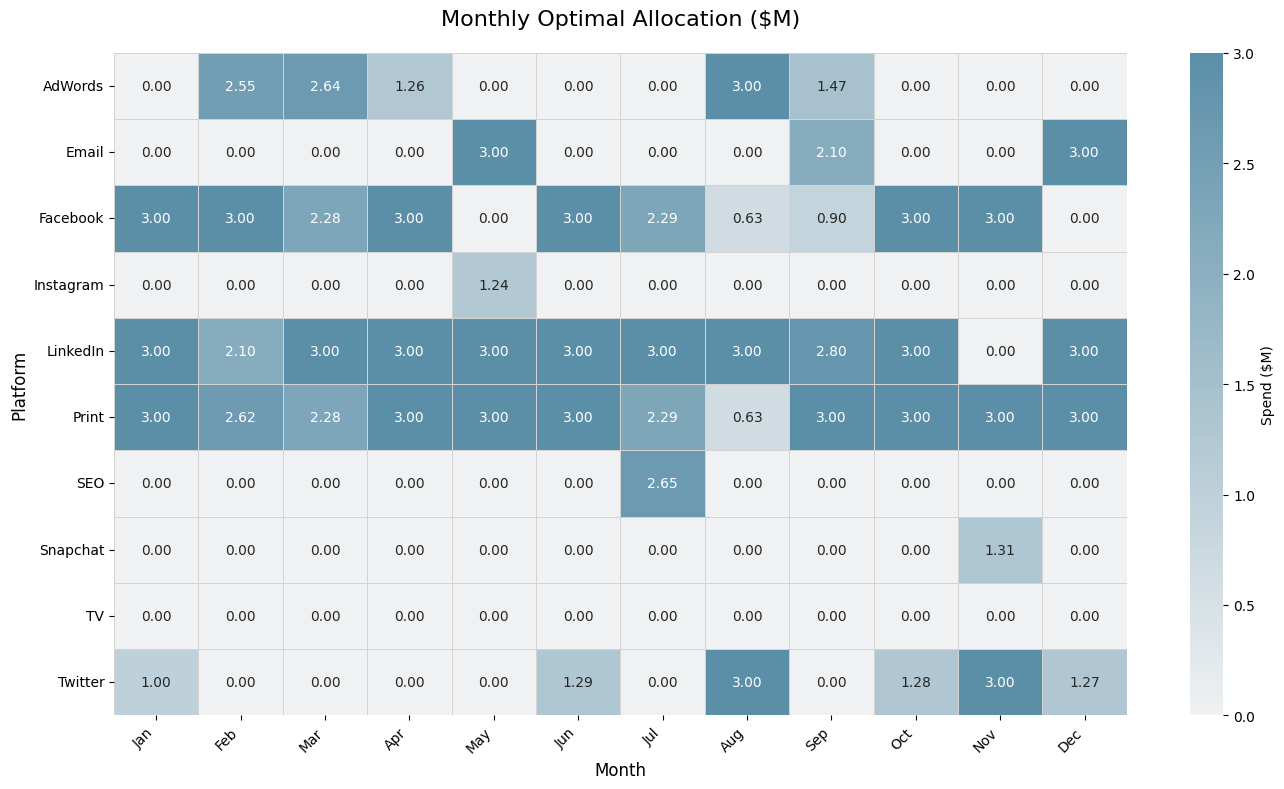

In [14]:
# === Monthly Reinvestment MIP (With Min Investment Applied) ===

import seaborn as sns

# Constants (in millions of dollars)
CAP_M = 3.0  # $3M per platform
INITIAL_BUDGET_M = 10.0  # $10M
REINVESTMENT_RATE = 0.50

# Input prep 
roi_monthly = roi_monthly.copy()
roi_monthly["UpperBoundM"] = roi_monthly["UpperBoundM"].replace([np.inf, -np.inf], CAP_M) # cap at 3.0M
roi_monthly["LowerBoundM"] = pd.to_numeric(roi_monthly["LowerBoundM"], errors="coerce")
roi_monthly["UpperBoundM"] = pd.to_numeric(roi_monthly["UpperBoundM"], errors="coerce")
roi_monthly["ROI"]          = pd.to_numeric(roi_monthly["ROI"], errors="coerce")
roi_monthly.dropna(subset=["LowerBoundM","UpperBoundM","ROI"], inplace=True)


# --- Filter ---
roi_monthly = roi_monthly[roi_monthly["UpperBoundM"] > roi_monthly["LowerBoundM"]].copy()
roi_monthly["Tier"] = roi_monthly["Tier"].astype(int)

# Month order and platform set
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
months      = sorted(roi_monthly["Month"].unique(), key=lambda m: month_order.index(m))
platforms   = sorted(roi_monthly["Platform"].unique())

n_months = len(months)
n_platforms = len(platforms)

# Platform categories for boss constraints
SOCIAL = ["Facebook", "LinkedIn", "Instagram", "Snapchat", "Twitter"]
SEARCH = ["SEO", "AdWords"]

# Solve month by month with reinvestment
total_return_all_m = 0.0
total_budget_all_m = 0.0
q7_allocations = []

# Minimum investment map
min_map = min_amount.set_index("Platform")["MinInvestment"]

# --- Initialize return in millions ---
month_return_m = 0.0
month_return_pct = 0.0
budget_m = 0.0


print("Monthly Reinvestment Model (with minimum investment constraint)\n")

for month in months:
    # --- REINVESTMENT LOGIC---
    budget_m = INITIAL_BUDGET_M + (REINVESTMENT_RATE * month_return_pct * INITIAL_BUDGET_M)
    
    # --- Print in full dollars ---
    print(f"{month}: Budget = ${budget_m * 1_000_000:,.2f}")

    # Get data for this month
    df_month = roi_monthly[roi_monthly.Month == month].copy()
    
    # Calculate TierWidth 
    df_month['TierWidth'] = df_month['UpperBoundM'] - df_month['LowerBoundM']
    
    # Filter out invalid tiers (added a small tolerance for stability)
    df_month = df_month[df_month['TierWidth'] > 1e-6].copy()

    # Create dictionaries 
    tier_width_m = {(row.Platform, row.Tier): row.TierWidth for _, row in df_month.iterrows()}
    tier_roi = {(row.Platform, row.Tier): row.ROI for _, row in df_month.iterrows()}
    tier_keys = list(tier_width_m.keys())

    # Model
    m = gp.Model(f"Month_{month}")
    m.Params.OutputFlag = 0
    
    # Variables (x_tier represents spend in millions)
    x_tier = m.addVars(tier_keys, lb=0, name="x_tier")
    y_tier = m.addVars(tier_keys, vtype='B', name="y_tier")
    
    # Total spend per platform (in millions)
    x_plat = {p: gp.quicksum(x_tier[p, t] for t in df_month[df_month.Platform == p].Tier)
              for p in df_month.Platform.unique()}
    
    # Platform-level binaries
    y_plat = m.addVars(list(df_month.Platform.unique()), vtype=GRB.BINARY, name="y_plat")

    # Link tier binaries to platform binaries
    for p in df_month.Platform.unique():
        tiers = sorted(df_month[df_month.Platform == p].Tier.tolist())
        for t in tiers:
            m.addConstr(y_tier[p, t] <= y_plat[p])
    
    # Minimum-investment linking (in millions)
    for p in df_month.Platform.unique():
        min_invest_m = float(min_map.get(p, 0.0))
        m.addConstr(x_plat[p] >= min_invest_m * y_plat[p])
        m.addConstr(x_plat[p] <= CAP_M * y_plat[p])
    
    # Budget constraint (in millions)
    m.addConstr(gp.quicksum(x_plat.values()) <= budget_m)
    
    # Per-platform cap (in millions)
    for p in df_month.Platform.unique():
        m.addConstr(x_plat[p] <= CAP_M)
    
    # Sequential tiers (in millions)
    for p in df_month.Platform.unique():
        tiers = sorted(df_month[df_month.Platform == p].Tier.tolist())
        for i, t in enumerate(tiers):
            m.addConstr(x_tier[p, t] <= tier_width_m[(p, t)] * y_tier[p, t])
            if i < len(tiers) - 1:
                t_next = tiers[i+1]
                m.addConstr(y_tier[p, t_next] <= y_tier[p, t])
                m.addConstr(x_tier[p, t] >= tier_width_m[(p, t)] * y_tier[p, t_next])

    # Boss constraints (ratios are scale-invariant)
    if "Print" in x_plat and "Facebook" in x_plat and "Email" in x_plat:
        if "TV" in x_plat:
            m.addConstr(x_plat["Print"] + x_plat["TV"] <= x_plat["Facebook"] + x_plat["Email"])
        else:
            m.addConstr(x_plat["Print"] <= x_plat["Facebook"] + x_plat["Email"])

    social_plats = [p for p in SOCIAL if p in x_plat]
    search_plats = [p for p in SEARCH if p in x_plat]
    if social_plats and search_plats:
        m.addConstr(gp.quicksum(x_plat[p] for p in social_plats) >=
                      2 * gp.quicksum(x_plat[p] for p in search_plats))

    # Objective (return in millions of dollars)
    m.setObjective(gp.quicksum(x_tier[p,t] * tier_roi[(p,t)] for (p,t) in tier_keys),
                     GRB.MAXIMIZE)

    m.optimize()

    # Results 
    if m.status == GRB.OPTIMAL:
        month_return_m = m.objVal  # Return in millions
        month_return_pct = month_return_m / budget_m  # Stable: M / M
        total_return_all_m += month_return_m
        total_budget_all_m += budget_m
        
        # --- Print in full dollars ---
        print(f"  Return = ${month_return_m * 1_000_000:,.2f}, ROI = {month_return_pct*100:.4f}%\n")

        # Save allocations 
        q7_allocations.append({
            p: float(sum(x_tier[p, t].X for t in df_month[df_month.Platform==p].Tier if (p,t) in x_tier))
            for p in platforms
        })
    else:
        print(f"Optimization failed for {month}")
        break

# Summary 
print(f"\nTotal Return: ${total_return_all_m*1000000:,.0f}")
print(f"Overall ROI: {(total_return_all_m / total_budget_all_m) * 100:.2f}%")

# Build allocation matrix 
alloc_df = pd.DataFrame(0.0, index=platforms, columns=months)
for mi, month in enumerate(months):
    month_alloc = q7_allocations[mi]
    for p in platforms:
        # --- Value is already in millions, no division needed ---
        alloc_df.at[p, month] = float(month_alloc.get(p, 0.0))

print("\nMonthly Optimal Allocation ($M)\n")

my_color = "#5B8FA8" 

# Create a sequential colormap from the color
custom_cmap = sns.light_palette(my_color, as_cmap=True)

# Set up the matplotlib figure
plt.figure(figsize=(14, 8)) # Adjust size as needed

# Create the heatmap using the custom_cmap
sns.heatmap(
    alloc_df,
    annot=True,          # Show the numbers in each cell
    fmt=".2f",           # Format numbers to 2 decimal places
    cmap=custom_cmap,    
    linewidths=0.5,      # Add thin lines between cells
    linecolor='lightgrey',
    cbar_kws={'label': 'Spend ($M)'} # Label for the color bar
)

# Add titles and labels
plt.title("Monthly Optimal Allocation ($M)", fontsize=16, pad=20)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Platform", fontsize=12)
plt.xticks(rotation=45, ha="right") # Rotate month labels for readability
plt.yticks(rotation=0)             # Keep platform labels horizontal

# Show the plot
plt.tight_layout()
plt.show()

## Analysis: Monthly Model with Reinvestment

The multi-period MIP dynamically allocates budget across 12 months using the monthly ROI forecasts. At the start of January, the budget is \$10M. Each month, **50% of the return generated in the prior month is added to the next month's budget** (which is based on the $10M initial budget), creating a *compounding effect*.

Because each investment cycle adjusts the available budget, the model dynamically shifts spend toward platforms with the highest ROI in any given month.

### Key Allocation Patterns Observed

From the optimal allocation matrix:

| Platform | Behavior Across Months |
| :--- | :--- |
| **LinkedIn, Facebook, Print** | Dominant platforms — repeatedly funded at or near the \$3M cap. |
| **AdWords & SEO** | Selected only in months where ROI spikes (e.g., AdWords in Q1/Q3, SEO in July). |
| **Instagram, TV, Email** | Used intermittently (e.g., Email/Instagram in May, Email in Dec). TV was not selected. |
| **Snapchat, Twitter** | Used intermittently, likely to satisfy Social ≥ 2 × Search or other constraints. |

The model is **not evenly diversifying** — it aggressively concentrates spending on the **highest-ROI platforms within each month**, which is optimal for return maximization.

### Compounding Return Effect

Because investments generate return, the available budget changes each month. A high-return month (like **Jan, \$539k**) leads to a larger budget for the next month (**Feb, \$10.27M**). A lower-return month (**Feb, \$421k**) leads to a slightly smaller budget for its successor (**Mar, \$10.20M**). This creates a "snowball effect" where profits fuel future investments.

Hence, **Total return over 12 months: \$6.455M**

That is significantly higher than the single-period MIP return of only **\$0.453M**, because here:

* investment → return → reinvestment → different future budgets
* the model selects platforms based on *monthly* ROI variation rather than static ROI values
* the compounding budget effect allows the model to react to market conditions

The model essentially creates a "snowball effect": profitable months fuel bigger investment opportunities later.

### Key Takeaways

1.  **Compounding returns matter**
    The reinvestment rule dramatically increases total return (from 0.453M in the static MIP to **\$6.455M** over 12 months).

2.  **Platform choice shifts dynamically**
    The model does not stick to one allocation strategy — it shifts based on monthly ROI trends (e.g., funding AdWords in Feb-Apr but not in May).

3.  **Minimum spend + business constraints force tactical diversification**
    At times, even if another platform has a higher ROI, the model must invest in Facebook or Email to satisfy:
    * `Print + TV ≤ Facebook + Email`
    * `Social ≥ 2 × (SEO + AdWords)`
    * `MinInvestment` constraint

4.  **Marketing behaves like a portfolio optimization problem**
    When budget can grow, the model prioritizes high-ROI platforms *early* so that later months benefit from increased budget capacity.

## Recommendation

**Front-load spending into the highest-ROI platforms early in the year**.

The results show that investing heavily in **LinkedIn + Facebook + Print** in early months generates strong returns, which:

*Translates into larger budgets later, enabling more aggressive allocations.*

Additionally:

* Monitor monthly ROI shifts — if a platform temporarily spikes (e.g., AdWords or SEO), capture the opportunity.
* Keep the reinvestment rule: it directly boosts total return.

## Sensitivity Check — What happens if we remove the minimum spend rule?

In the previous model, we enforced a business rule:

If a platform is selected, we must invest at least its minimum required spend.

To understand whether this rule limits performance, we now **relax that constraint** and allow the optimizer to invest any amount (including tiny exploratory spends) as long as all other constraints remain satisfied:

* Tier selection still works via z[p,t] binaries.
* Spend interpolation inside a tier still uses s[p,t].
* Monthly reinvestment, Print+TV ≤ Facebook+Email, and Social ≥ 2×Search are all still enforced.

This experiment *isolates the impact of the minimum-investment rule on performance*. If relaxing the constraint leads to a meaningfully higher total return, it suggests the rule is restrictive. If results barely change, the rule is harmless and provides managerial clarity without sacrificing value.

Monthly Reinvestment Model (Scaled to $M) — Relaxed (No Min Investment)

Jan: Budget = $10,000,000
  Return = $539,420, ROI = 5.3942%

Feb: Budget = $10,269,710
  Return = $420,890, ROI = 4.0984%

Mar: Budget = $10,204,918
  Return = $534,580, ROI = 5.2385%

Apr: Budget = $10,261,923
  Return = $501,732, ROI = 4.8893%

May: Budget = $10,244,463
  Return = $600,517, ROI = 5.8619%

Jun: Budget = $10,293,094
  Return = $484,958, ROI = 4.7115%

Jul: Budget = $10,235,574
  Return = $546,974, ROI = 5.3439%

Aug: Budget = $10,267,193
  Return = $551,788, ROI = 5.3743%

Sep: Budget = $10,268,714
  Return = $568,780, ROI = 5.5390%

Oct: Budget = $10,276,948
  Return = $646,191, ROI = 6.2878%

Nov: Budget = $10,314,389
  Return = $551,328, ROI = 5.3452%

Dec: Budget = $10,267,262
  Return = $508,069, ROI = 4.9484%


Monthly Optimal Allocation (Relaxed — No Min Investment ($M))

Total Return: $6,455,226
Overall ROI: 5.25%

Monthly Optimal Allocation (Relaxed — No Min Investment) ($M)



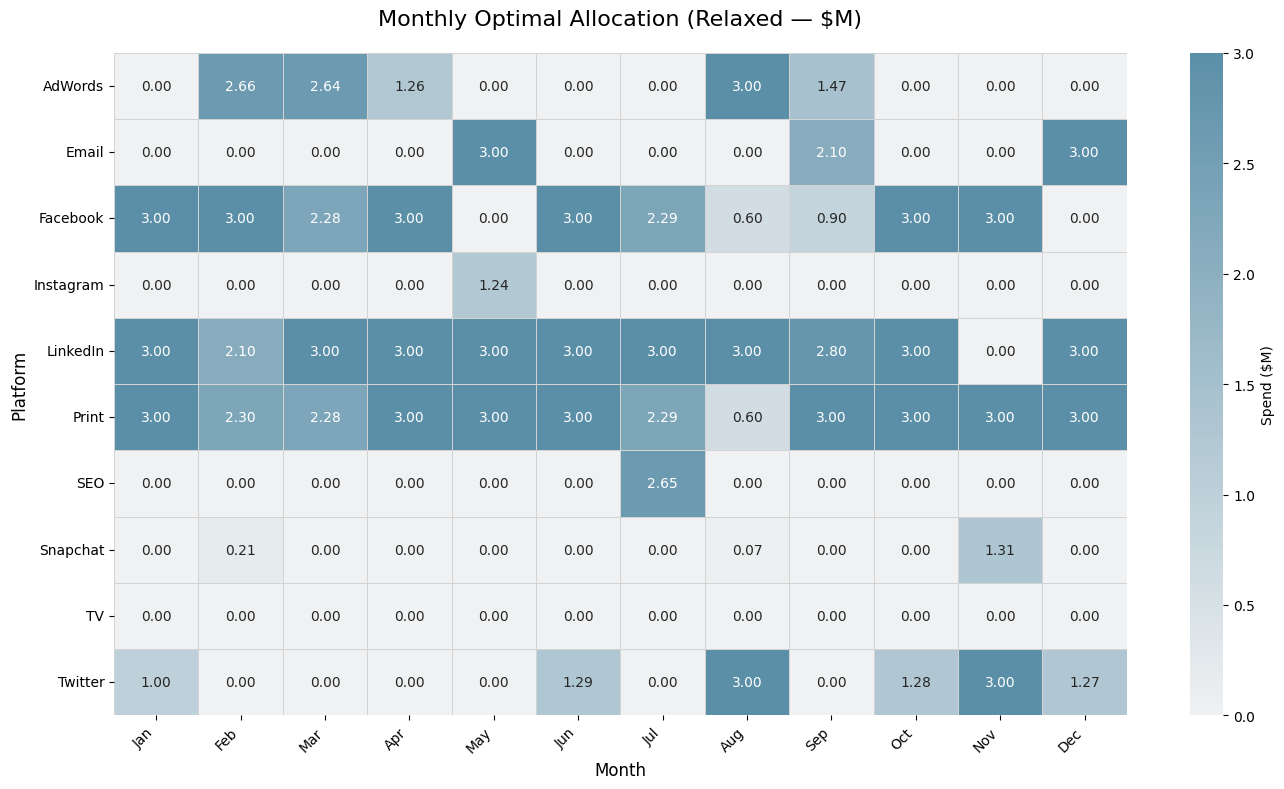

In [15]:
# === Monthly Reinvestment MIP — Relaxed (No Min Investment) ===

# Constants (in millions of dollars for the model)
CAP_M = 3.0                     # $3M per platform
INITIAL_BUDGET_M = 10.0         # $10M
REINVESTMENT_RATE = 0.50        # 50% of prev-month ROI% * base budget

# Input prep 

roi_data_relaxed = roi_monthly.copy() 
roi_data_relaxed["UpperBoundM"] = roi_data_relaxed["UpperBoundM"].replace([np.inf, -np.inf], CAP_M) # cap at 3.0M
roi_data_relaxed["LowerBoundM"] = pd.to_numeric(roi_data_relaxed["LowerBoundM"], errors="coerce")
roi_data_relaxed["UpperBoundM"] = pd.to_numeric(roi_data_relaxed["UpperBoundM"], errors="coerce")
roi_data_relaxed["ROI"]          = pd.to_numeric(roi_data_relaxed["ROI"], errors="coerce")
roi_data_relaxed.dropna(subset=["LowerBoundM","UpperBoundM","ROI"], inplace=True)


# --- Filter  ---
roi_data_relaxed = roi_data_relaxed[roi_data_relaxed["UpperBoundM"] > roi_data_relaxed["LowerBoundM"]].copy()
roi_data_relaxed["Tier"] = roi_data_relaxed["Tier"].astype(int)

# Month order and platform set 
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
months      = sorted(roi_data_relaxed["Month"].unique(), key=lambda m: month_order.index(m))
platforms   = sorted(roi_data_relaxed["Platform"].unique())

# Boss constraint groups
SOCIAL = ["Facebook", "LinkedIn", "Instagram", "Snapchat", "Twitter"]
SEARCH = ["SEO", "AdWords"]

# --- Initialize tracking variables ---
total_return_relax_usd = 0.0
total_budget_relax_usd = 0.0
q7_allocations_relax_list = [] 
prev_month_roi_pct_relax = 0.0 
budget_relax_m = 0.0 # This will be set in the loop

print("Monthly Reinvestment Model (Scaled to $M) — Relaxed (No Min Investment)\n")

for month in months:
    # --- Budget calculation in $M ---
    budget_relax_m = INITIAL_BUDGET_M + REINVESTMENT_RATE * prev_month_roi_pct_relax * INITIAL_BUDGET_M
    
    # --- Print in full dollars ---
    print(f"{month}: Budget = ${budget_relax_m * 1_000_000:,.0f}")

    # Month slice and tier widths (in $M)
    # --- SLICING FROM THE NEW VARIABLE ---
    df_month_relax = roi_data_relaxed[roi_data_relaxed["Month"] == month].copy()
    
    # --- Calculate TierWidth ---
    df_month_relax["TierWidth"] = df_month_relax["UpperBoundM"] - df_month_relax["LowerBoundM"]
    df_month_relax = df_month_relax[df_month_relax["TierWidth"] > 1e-6].copy() # Use small tolerance
    df_month_relax["Tier"] = df_month_relax["Tier"].astype(int)

    # Dicts for model (all values in $M)
    tier_width_relax_m = {(r.Platform, int(r.Tier)): float(r.TierWidth) for _, r in df_month_relax.iterrows()}
    tier_roi_relax     = {(r.Platform, int(r.Tier)): float(r.ROI)         for _, r in df_month_relax.iterrows()}
    tier_keys_relax    = list(tier_width_relax_m.keys())

    # Model (Gurobi)
    m_relax2 = gp.Model(f"Month_{month}_Relaxed")
    m_relax2.Params.OutputFlag     = 0
    m_relax2.Params.Threads        = 1
    m_relax2.Params.Seed           = 0
    m_relax2.Params.NumericFocus   = 1
    
    # Vars (x_tier_relax is spend in $M)
    x_tier_relax = m_relax2.addVars(tier_keys_relax, lb=0.0, name="x_tier_relax") 
    y_tier_relax = m_relax2.addVars(tier_keys_relax, vtype=GRB.BINARY, name="y_tier_relax")

    # Total spend per platform (in $M)
    x_plat_relax = {
        p: gp.quicksum(x_tier_relax[p, t] for t in df_month_relax.loc[df_month_relax.Platform == p, "Tier"])
        for p in df_month_relax["Platform"].unique()
    }

    # Budget equality (in $M)
    m_relax2.addConstr(gp.quicksum(x_plat_relax.values()) == budget_relax_m)

    # Per-platform cap (in $M)
    for p in df_month_relax["Platform"].unique():
        m_relax2.addConstr(x_plat_relax[p] <= CAP_M)

    # Prefix tiers (sequential, in $M)
    for p in df_month_relax["Platform"].unique():
        tiers_p = sorted(df_month_relax.loc[df_month_relax.Platform == p, "Tier"].astype(int).tolist())
        for i, t in enumerate(tiers_p):
            # --- Use tier_width_relax_m ---
            m_relax2.addConstr(x_tier_relax[p, t] <= tier_width_relax_m[(p, t)] * y_tier_relax[p, t])
            if i < len(tiers_p) - 1:
                t_next = tiers_p[i + 1]
                m_relax2.addConstr(y_tier_relax[p, t_next] <= y_tier_relax[p, t])
                m_relax2.addConstr(x_tier_relax[p, t] >= tier_width_relax_m[(p, t)] * y_tier_relax[p, t_next])

    # Boss constraints 
    if "Print" in x_plat_relax and "Facebook" in x_plat_relax and "Email" in x_plat_relax:
        if "TV" in x_plat_relax:
            m_relax2.addConstr(x_plat_relax["Print"] + x_plat_relax["TV"] <= x_plat_relax["Facebook"] + x_plat_relax["Email"])
        else:
            m_relax2.addConstr(x_plat_relax["Print"] <= x_plat_relax["Facebook"] + x_plat_relax["Email"])

    social_plats_relax = [p for p in SOCIAL if p in x_plat_relax]
    search_plats_relax = [p for p in SEARCH if p in x_plat_relax]
    if social_plats_relax and search_plats_relax:
        m_relax2.addConstr(
            gp.quicksum(x_plat_relax[p] for p in social_plats_relax) >=
            2.0 * gp.quicksum(x_plat_relax[p] for p in search_plats_relax)
        )

    # Objective: maximize total return (in $M)
    m_relax2.setObjective(
        gp.quicksum(x_tier_relax[p, t] * tier_roi_relax[(p, t)] for (p, t) in tier_keys_relax),
        GRB.MAXIMIZE
    )

    m_relax2.optimize()

    if m_relax2.status != GRB.OPTIMAL:
        print(f"Optimization failed for {month} (status {m_relax2.status})")
        break

    # Build month allocation, converting from $M back to $USD
    month_alloc = {}
    for p in df_month_relax["Platform"].unique():
        tiers_p = df_month_relax.loc[df_month_relax.Platform == p, "Tier"].astype(int).tolist()
        month_alloc[p] = float(sum(x_tier_relax[p, t].X for t in tiers_p)) * 1_000_000
        
    for p in platforms:
        month_alloc.setdefault(p, 0.0)
    q7_allocations_relax_list.append(month_alloc) # List now holds full $USD

    # Monthly return (in $M) and ROI%
    month_ret_relax_m = float(m_relax2.objVal) # absolute $M
    
    # --- SAFETY CHECK: Avoid ZeroDivisionError ---
    prev_month_roi_pct_relax = month_ret_relax_m / budget_relax_m 

    # --- Store $USD for reporting ---
    month_ret_relax_usd = month_ret_relax_m * 1_000_000
    total_return_relax_usd += month_ret_relax_usd
    total_budget_relax_usd += budget_relax_m * 1_000_000

    # --- Print in full dollars ---
    print(f"  Return = ${month_ret_relax_usd:,.0f}, ROI = {100*prev_month_roi_pct_relax:.4f}%\n")


# Summary and allocation table 
print("\nMonthly Optimal Allocation (Relaxed — No Min Investment ($M))\n")
print(f"Total Return: ${total_return_relax_usd:,.0f}")
overall_roi_pct = (total_return_relax_usd / total_budget_relax_usd) * 100.0 if total_budget_relax_usd > 0 else 0.0
print(f"Overall ROI: {overall_roi_pct:.2f}%")

# Build platform × month matrix (USD)
alloc_df_relaxed = pd.DataFrame(0.0, index=platforms, columns=months)
for mi, month in enumerate(months):
    for p in platforms:
        alloc_df_relaxed.at[p, month] = q7_allocations_relax_list[mi].get(p, 0.0)

print("\nMonthly Optimal Allocation (Relaxed — No Min Investment) ($M)\n")

alloc_df_relaxed_m = alloc_df_relaxed / 1_000_000

# Define the custom base color
my_color = "#5B8FA8" 

# Create a sequential colormap from the color
custom_cmap = sns.light_palette(my_color, as_cmap=True)

# Set up the matplotlib figure
plt.figure(figsize=(14, 8)) 

# Create the heatmap
sns.heatmap(
    alloc_df_relaxed_m,  # Use the $M DataFrame
    annot=True,          # Show the numbers in each cell
    fmt=".2f",           # Format numbers to 2 decimal places (now in $M)
    cmap=custom_cmap,    
    linewidths=0.5,      # Add thin lines between cells
    linecolor='lightgrey',
    cbar_kws={'label': 'Spend ($M)'} # Label for the color bar
)

# Add titles and labels
plt.title("Monthly Optimal Allocation (Relaxed — $M)", fontsize=16, pad=20)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Platform", fontsize=12)
plt.xticks(rotation=45, ha="right") # Rotate month labels for readability
plt.yticks(rotation=0)             # Keep platform labels horizontal

# Show the plot
plt.tight_layout()
plt.savefig("monthly_alloc_relaxed_heatmap.png")
plt.show()

## Impact of Relaxing Minimum Investment Constraint

Relaxing the minimum-investment rule results in a **minor increase** in total return to **\$6,455,226** (a gain of +\$184 over the constrained model's **\$6,455,042**). The **Overall ROI remains 5.25%**.

The core allocation pattern remains focused on Print, Facebook, and LinkedIn. However, the allocation matrix shows **minor "drift"** as the model is now free to make small "micro-optimizations" that were previously forbidden.

### Why Such a Minor Change?

The minimum-spend constraint *was* technically **binding, but it only affected small micro-allocations**.

* In the original model, the optimizer was prevented from making small, high-ROI investments that were below the minimum threshold (e.g., investing in Snapchat).
* Removing the constraint **unlocks these minor opportunities**. The model now adds small investments where it sees value (e.g., **\$0.21M in Snapchat in Feb** and **\$0.07M in Aug**).
* This new spend causes a slight "ripple effect," freeing up capital from other platforms (like Print in Feb) to be re-allocated. These tiny adjustments are what account for the +$184 gain.

### Takeaway:

The minimum-spend rule **has a negligible impact on total return** (costing only $184/year). The core strategy remains unchanged.

The rule's primary effect is preventing small, tactical "micro-buys." While keeping the rule is *technically* suboptimal, it simplifies operations by preventing fragmented investments, which may be a worthwhile business trade-off for a near-zero performance cost.

# Stability Check — Limiting Month-to-Month Budget Volatility

In the previous task, we optimized the budget across 12 months, allowing the model to shift spending freely in response to ROI changes and reinvestment growth.

However, we now introduce a **practical operational constraint**:

"A *stable* marketing plan should not change spend by more than **\$1M per platform between months**."

In other words, a platform's monthly budget should evolve smoothly rather than jumping abruptly.

Formally, stability requires:

$$|x_{p,m} - x_{p,m-1}| \le 1 \qquad \forall \text{ platform } p, \; \forall \text{ months } m \ge 2$$

Where:
* $x_{p,m}$ = spend on platform $p$ in month $m$

## Objective

We check whether the optimal monthly allocation (with minimum investment constraint) already satisfies this stability condition.

## Implementation

1. Read in the optimal monthly allocation $x_{p,m}$
2. Measure the **largest month-to-month change** per platform
3. Reports whether the allocation is stable based on the \$1M threshold
4. Prints the stable allocation if solved with stability constraints


Max monthly change across all platforms: $3.000M
Stable? NO
Δ spend ($M) vs prior month (cells > $1.00M highlighted):


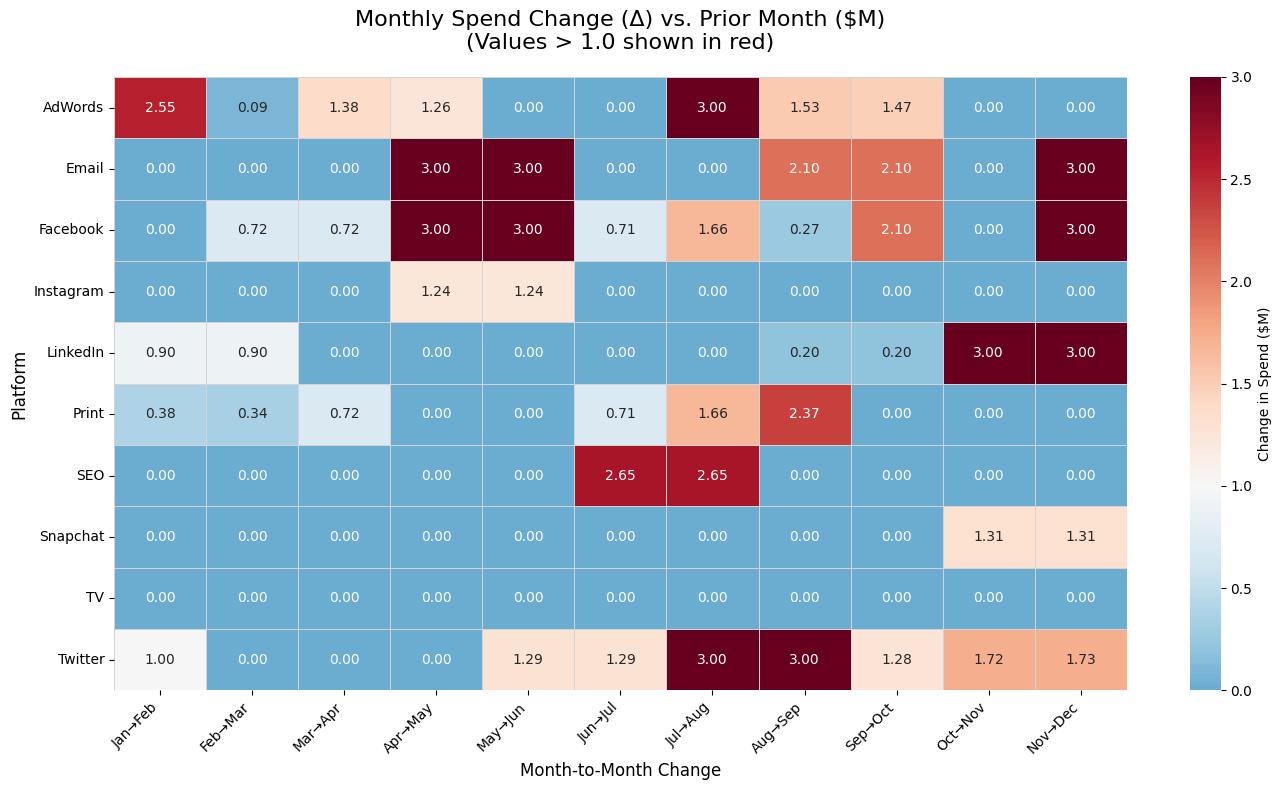


Platforms with ≥1 violation: 9 / 10
Total cells exceeding $1M change: 33


In [16]:
# Allocation Stability Check 

THRESHOLD = 1.0  # $1M change allowed between consecutive months

# Month→month column labels, e.g., "Jan→Feb"
month_steps = [f"{months[i-1]}→{months[i]}" for i in range(1, n_months)]

# Use the alloc_df you just built (rows=platforms, cols=months)
# Compute absolute month-to-month deltas per platform
delta_mat = np.abs(alloc_df.values[:, 1:] - alloc_df.values[:, :-1])
delta_df = pd.DataFrame(delta_mat, index=platforms, columns=month_steps)

# Violation booleans and counts
viol_bool = delta_df > THRESHOLD
viol_per_platform = viol_bool.sum(axis=1)
viol_per_step = viol_bool.sum(axis=0)

# Append per-step totals row
delta_with_totals = delta_df.copy()
delta_with_totals.loc["# Violations (per step)"] = viol_per_step.values

# Add per-platform totals column
summary_col = pd.Series(viol_per_platform, name="# Violations").astype(int)
summary_col.loc["# Violations (per step)"] = int(viol_per_step.sum())

# Styling helpers
def highlight_exceeds(df):
    styles = np.full(df.shape, "", dtype=object)
    mask = df.values > THRESHOLD
    styles[mask] = "background-color:#f5b7b1; font-weight:bold;"  # soft red
    return styles

def format_two_decimals(x):
    try:
        return f"{x:.2f}"
    except Exception:
        return x

# Combine data and show
table = pd.concat([delta_with_totals, summary_col], axis=1)

max_change = float(delta_mat.max())
print("\nMax monthly change across all platforms:", f"${max_change:.3f}M")
print("Stable?" + (" YES" if max_change <= THRESHOLD else " NO"))
print("Δ spend ($M) vs prior month (cells > $1.00M highlighted):")

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create the heatmap
sns.heatmap(
    delta_df,            # Use the raw delta data
    annot=True,          # Show the numbers in each cell
    fmt=".2f",           # Format numbers to 2 decimal places
    linewidths=0.5,
    linecolor='lightgrey',
    cmap="RdBu_r",       
    center=THRESHOLD,    # This centers the color scale on 1.0
    
    cbar_kws={'label': 'Change in Spend ($M)'} # Label for the color bar
)

# Add titles and labels
plt.title(f"Monthly Spend Change (Δ) vs. Prior Month ($M)\n(Values > {THRESHOLD} shown in red)", 
          fontsize=16, pad=20)
plt.xlabel("Month-to-Month Change", fontsize=12)
plt.ylabel("Platform", fontsize=12)
plt.xticks(rotation=45, ha="right") # Rotate month labels
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.savefig("monthly_spend_delta_heatmap.png")
plt.show()

total_violations = int(viol_bool.values.sum())
platforms_violated = int((viol_bool.any(axis=1)).sum())

print(f"\nPlatforms with ≥1 violation: {platforms_violated} / {len(platforms)}")
print(f"Total cells exceeding $1M change: {total_violations}")

## Analysis — Monthly Stability Check (Δ Spend ≤ $1M)

To assess whether the **12-month dynamic allocation** is *stable*, we computed the change in spend for every platform across all month-to-month transitions.

The output reveals:

* **Max monthly change:** \$3.000M (violates stability rule by 3× the allowed jump)
* **Platforms violating the rule:** **9 out of 10**
* **Total instability violations:** **33 month-platform changes > \$1M**
* Several platforms show repeated sharp reallocations (Twitter, AdWords, Facebook, Email)

Heatmap interpretation:

| What it shows | Meaning |
| :--- | :--- |
| Orage/Red cells | Spend jumped more than $1M — violates stability rule |
| Blue cells | Small or no adjustment month-to-month |

The heatmap reveals that many platforms frequently swing between **\$0M ⇒ \$3M ⇒ \$0M**, especially:

* Twitter (7 violations)
* AdWords (6 violations)
* Facebook (5 violations)
* Email (5 violations)

These sharp reallocations are consistent with maximizing return under tier-based ROI: the MIP jumps into whichever platform has the highest ROI that month.

### Conclusion

**The allocation is not stable.**

The optimal solution maximizes total return, not consistency. The compounding reinvestment effect encourages the model to aggressively chase whichever platform has the highest monthly ROI.

## How we could enforce stability (conceptual modeling)

To make spending stable, we would add a new constraint to the MIP:

For every platform $p$ and month $m$:

$$
|x_{p,m} - x_{p,m-1}| \le 1
$$

In Gurobi, absolute value requires linearization. We would introduce a slack variable or binary variable to enforce:

$$
x_{p,m} - x_{p,m-1} \le 1
$$

$$
x_{p,m-1} - x_{p,m} \le 1
$$

This guarantees that **spend adjustments are gradual** — no sudden jumps.

## Recommendation

If marketing leadership values **consistency and operational feasibility** more than absolute maximum ROI:

* Add the stability constraint.
* Expect a slightly lower annual return possibility.

If maximizing ROI is the priority (e.g., short-term revenue push):

* Keep current model — aggressive reallocation yields a higher compounded return.

The current allocation is **optimal but not human-operationally realistic**. A stable-constrained version would better reflect real-world execution.

### References:

* Core concepts and methodology were primarily based on class lecture notes
* AI was used to speed up certain parts of the project, such as understanding the concept of budget allocation, debugging and improving explanation clarity.
* All modeling decisions, optimization logic, implementation, and interpretation of results are our own.

------------------------------------ END OF REPORT -------------------------------------